# **Machine Learning Reconstruction of Surface Ocean pCO₂**

Spring 2025, EESC4243/STAT4243/5243 “Climate Prediction Challenges with Machine Learning”, Columbia University

Group 4: Dhruv Chakraborty, Andrew Marshall Fagerheim, Sam Anwar, Alex Crookshanks

## Introduction

We build upon a portion of the analysis carried out by  
**Gloege et al. (2021)** *"Quantifying Errors in Observationally Based Estimates of Ocean Carbon Sink Variability."* **Global Biogeochemical Cycles** 34: e2020GB006788. ([DOI: 10.1029/2020GB006788](https://doi.org/10.1029/2020GB006788))  

using the method of  
**Bennington et al. (2022)** *"Explicit Physical Knowledge in Machine Learning for Ocean Carbon Flux Reconstruction: The pCO2-Residual Method"*. **Journal of Advances in Modeling Earth Systems**, 14(10). ([DOI: 10.1029/2021ms002960](https://doi.org/10.1029/2021ms002960))

Our work expands on the existing analysis by testing several ways to improve bias, correlation, and RMSE in the XGBoost model. We tested five different approaches against our baseline from the starter notebook:

<div style="background-color: #e7f2f6; padding: 15px; border-left: 6px solid #bfbfbf; font-size: 16px;">
    <h3>Approaches</h3>
    <ul style="list-style-type: none; padding-left: 0;">
        <li style="margin-bottom: 12px;">
            <a href="https://github.com/dhruvc99/LEAPCourse-Climate-Pred-Challenges/blob/main/Project-StarterCodes/Project3-ReconstructPCO2/notebooks/Project3_Starter.ipynb" target="_blank"><b>Baseline: Project 3 starter notebook</b></a>
        </li>
        <li style="margin-bottom: 12px;">
            <a href="https://github.com/dhruvc99/LEAPCourse-Climate-Pred-Challenges/blob/main/Project-StarterCodes/Project3-ReconstructPCO2/notebooks/Project_3_Modify_Loss_Function.ipynb" target="_blank"><b>Modified loss function</b></a>
            <ul>
                <li><b>Summary:</b></li>
                <li><b>Motivation:</b></li>
            </ul>
        </li>
        <li style="margin-bottom: 12px;">
            <a href="https://github.com/dhruvc99/LEAPCourse-Climate-Pred-Challenges/blob/main/Project-StarterCodes/Project3-ReconstructPCO2/notebooks/Project3_finetune.ipynb" target="_blank"><b>Latitudinal split</b></a>
            <ul>
                <li><b>Summary:</b></li>
                <li><b>Motivation:</b></li>
            </ul>
        </li>
        <li style="margin-bottom: 12px;">
            <a href="https://github.com/dhruvc99/LEAPCourse-Climate-Pred-Challenges/blob/main/Project-StarterCodes/Project3-ReconstructPCO2/notebooks/Project3_Ocean_Clustering.ipynb" target="_blank"><b>Ocean split</b></a>
            <ul>
                <li><b>Summary:</b> Data is split into ocean basins and a separate XGBoost model is trained per basin, resulting in five models per ensemble member. Reconstructions are thus ocean-aware in its predictions. There is one reconstruction per member, derived from the five ocean-level models.</li>
                <li><b>Motivation:</b> Each ocean has its own physical, chemical, and biological makeup, and by constraining each ocean to its own model, we hope to better capture these unique elements. The XGBoost model can optimize splits differently for each region without the demands of optimizing for a global fit. Moreover, ocean models focus only on relevant variability, reducing noise and variance. This also helps combat the challenges of data sparsity. Areas with low sampling are not overinfluenced by their abundant counterparts.</li>
            </ul>
        </li>
        <li style="margin-bottom: 12px;">
            <a href="https://github.com/dhruvc99/LEAPCourse-Climate-Pred-Challenges/blob/main/Project-StarterCodes/Project3-ReconstructPCO2/notebooks/Project3_Starter-AEC-TransferLearning.ipynb" target="_blank"><b>Transfer learning</b></a>
            <ul>
                <li><b>Summary:</b></li>
                <li><b>Motivation:</b></li>
            </ul>
        </li>
        <li>
            <a href="https://github.com/dhruvc99/LEAPCourse-Climate-Pred-Challenges/blob/main/Project-StarterCodes/Project3-ReconstructPCO2/notebooks/Project3_Weighted_Samples.ipynb" target="_blank"><b>Weighted sampling</b></a>
            <ul>
                <li><b>Summary:</b></li>
                <li><b>Motivation:</b></li>
            </ul>
        </li>
    </ul>
</div>


## LET member selection and notebook logistics

We found that splitting the data into three longitudinal bands was most effective in improving evaluation metrics in the reconstruction of pCO2. 

In order to optimize the runtime of this notebook, reviewers will train and reconstruct member_r10i1p1f1 from ACCESS-ESM1-5, rather than run all five approaches for all nine members. The full list of members used in our analysis, standardized across all five approaches, is below.

* ACCESS-ESM1-5
    * member_r10i1p1f1
    * member_r2i1p1f1
    * member_r5i1p1f1
* CanESM5
    * member_r1i1p1f1
    * member_r1i1p2f1
    * member_r2i1p1f1
* MPI-ESM1-2-LR
    * member_r11i1p1f1
    * member_r12i1p1f1
    * member_r15i1p1f1

To view the training and reconstruction code for each approach, use the hyperlinks in the above "Approaches" markdown cell.

After using the latitudinal split approach to reconstruct a single member, this notebook loads in the evaluation metrics to compare all five approaches. Then, we dive in deeper into the latitudinal split approach by plotting more detailed results.

# 0. Set usernames and import necessary libraries

In [17]:
your_username = 'samanthaanwar'  # username of the person running the code. Reviewers should also change this to their own username.

#To allow the reviewer to access the saved files, provide notebook owner's username here:  
owner_username = 'dhruvc99'  # Reviewer should not change this name

In [2]:
%%capture
!pip install tensorflow
!pip install keras

In [3]:
%%capture
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path
import datetime
import cmocean as cm
import pickle
from collections import defaultdict
import csv

# machine learning libraries
import xgboost as xgb     
from xgboost import XGBRegressor

# Initialize filesystem
fs = gcsfs.GCSFileSystem()

# Change to the parent directory of the current working directory. 
# ***Run only once—otherwise it will keep moving up the directory tree***
os.chdir(os.path.dirname(os.getcwd()))
print("Current working directory:", os.getcwd())

# Import helper functions
from lib.visualization import *
from lib.bias_figure2 import concat_datasets, XarrayEvaluator
from lib.corr_figure3 import eval_spatial
from lib.results_load import load_corr_results, load_eval_results
import lib.residual_utils as supporting_functions

2025-04-28 20:16:12.161700: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-28 20:16:12.163809: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-28 20:16:12.167943: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-28 20:16:12.179299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745871372.198544    4203 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745871372.20

# 1. Training and reconstruction for latitudinal split approach

In [4]:
# features for ML:
features_sel = ['sst','sst_anom','sss','sss_anom','mld_clim_log','chl_log','chl_log_anom','xco2','A', 'B', 'C', 'T0', 'T1']

# the target variable we reconstruct:
target_sel = ['pco2_residual'] # this represents pCO2 - pCO2-T (calculated in notebook 00)

In [5]:
# Date range consistent with datasets
date_range_start = '2004-01-01T00:00:00.000000000'
date_range_end = '2023-12-31T00:00:00.000000000'
dates = pd.date_range(start=date_range_start, end=date_range_end, freq='MS')
init_date = str(dates[0].year) + format(dates[0].month,'02d')
fin_date = str(dates[-1].year) + format(dates[-1].month,'02d')

# List of approaches to compare
approaches = [
    'baseline', 
    'custom_loss', 
    'latitude_split', 
    'ocean_split', 
    'transfer_learning', 
    'weighted_samples'
]

# Dictionary to store results for each approach
approach_results = {}

# Models and members (consistent across approaches)
models = ['ACCESS-ESM1-5', 'CanESM5', 'MPI-ESM1-2-LR']
members = {
    'ACCESS-ESM1-5': ['member_r10i1p1f1', 'member_r2i1p1f1', 'member_r5i1p1f1'],
    'CanESM5': ['member_r1i1p1f1', 'member_r1i1p2f1', 'member_r2i1p1f1'],
    'MPI-ESM1-2-LR': ['member_r11i1p1f1', 'member_r12i1p1f1', 'member_r15i1p1f1']
}

# Base path
base_path = f'gs://leap-persistent/{your_username}/{owner_username}/pco2_residual'

# Path to SOCAT mask file for visualization
zarr_dir = 'gs://leap-persistent/abbysh/zarr_files_'
socat_path = f"{zarr_dir}/socat_mask_feb1982-dec2023.zarr"
socat_mask_data = xr.open_zarr(socat_path).sel(time=slice(str(dates[0]),str(dates[-1])))

In [6]:
### set up for getting files from leap bucket ###
fs = gcsfs.GCSFileSystem()

### paths for loading: ###
# directory of regridded members from notebook 00
ensemble_dir = "gs://leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members" # path to regridded data
path_seeds = "gs://leap-persistent/abbysh/pickles/random_seeds.npy" # random seeds for ML

# directory of reference zarr files
zarr_dir = 'gs://leap-persistent/abbysh/zarr_files_'

# socat data file
socat_path = f"{zarr_dir}/socat_mask_feb1982-dec2023.zarr"

# preprocessed ESM ensemble members
MLinputs_path = "gs://leap-persistent/Mukkke/pco2_residual/post01_xgb_inputs"

grid_search_approach = 'latitude_split'
output_dir = f'gs://leap-persistent/{your_username}/{owner_username}/pco2_residual/{grid_search_approach}/post02_xgb' # where to save machine learning results

model_output_dir = f"{output_dir}/trained" # where to save ML models
recon_output_dir = f"{output_dir}/reconstructions" # where to save ML reconstructions

metrics_output_dir = f'{output_dir}/metrics' # where to save performance metrics
test_perform_fname = f"{metrics_output_dir}/xgb_test_performance_{init_date}-{fin_date}.csv" # path for test performance metrics
unseen_perform_fname = f"{metrics_output_dir}/xgb_unseen_performance_{init_date}-{fin_date}.csv" # path for unseen performance metrics

xgb_model_save_dir = f'{output_dir}/saved_models_{init_date}-{fin_date}' # where to save .json model file
xgb_model_local_save_dir = "output/model_saved"


## 1.1 Data split

In [7]:
### train-validate-test split proportions ###

select_dates = []
test_dates = []

for i in range(0,len(dates)):
    if i % 5 != 0:
        select_dates.append(dates[i]) ### 80% train days set ###
    if i % 5 == 0:
        test_dates.append(dates[i]) ### 20% test days set ### 

### Then, the month numbers above are converted back to their respective datetime objects.

year_mon = []

for i in range(0,len(select_dates)):
    
    tmp = select_dates[i]
    year_mon.append(f"{tmp.year}-{tmp.month}")
    
test_year_mon = []

for i in range(0,len(test_dates)):
    
    tmp = test_dates[i]
    test_year_mon.append(f"{tmp.year}-{tmp.month}")

## 1.2 Hyperparameters

In [8]:
params = {
    'n_estimators': 500,  # Number of boosting rounds
    'max_depth': 6,  # Maximum depth of each tree to control model complexity
    'learning_rate': 0.05,  # Step size shrinkage to prevent overfitting
    'subsample': 0.8,  # Fraction of samples used for training each tree
    'colsample_bytree': 0.8,  # Fraction of features used per tree
    'gamma': 0.1,  # Minimum loss reduction required for further partitioning
    'min_child_weight': 5,  # Minimum sum of instance weight in a leaf node
    'reg_alpha': 0.1,  # L1 regularization to reduce model complexity
    'reg_lambda': 1.0,  # L2 regularization for preventing overfitting
    'objective': 'reg:squarederror',  # Loss function for regression tasks
    'n_jobs': 30,  # Number of parallel threads to use for training
    'eval_metric': 'rmse',
    'early_stopping_rounds': 50  # Stop training if performance doesn't improve for 50 rounds
}

## 1.3 ML Training

In [11]:
runthiscell = -1  # 0 will turn off, 1 will turn on, -1 will only run the first member. Reviewers should set this to -1.

if runthiscell: 
    random_seeds = np.load(fs.open(path_seeds))   
    
    seed_loc_dict = defaultdict(dict)
    for ens,mem_list in members.items():
        sub_dictt = dict()
        for no,mem in enumerate(mem_list):
            sub_dictt.update({mem:no})
        seed_loc_dict.update({ens:sub_dictt})
    
    val_prop = .2 # 20% of training data for validation
    test_prop = .0 # Since we apply this split to X_train, we set it to zero. We have X_test as testing dataset.
    
    print(datetime.datetime.now())

    if runthiscell == -1:
        print("Reviewing process: Running ML only for the first member of the first ESM.")
        first_ens = list(members.keys())[0]  # Get the first ensemble key
        first_mem = members[first_ens][0]   # Get the first member in that ensemble
        run_selected_mems_dict = {first_ens: [first_mem]}  # Create a dictionary with only the first ensemble and member
    else:
        run_selected_mems_dict = members
    
    for ens, mem_list in run_selected_mems_dict.items():
        for member in mem_list:
            print(ens, member)
            seed_loc = seed_loc_dict[ens][member]
            data_dir = f"{MLinputs_path}/{ens}/{member}"
            fname = f"MLinput_{ens}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.pkl"
            file_path = f"{data_dir}/{fname}"
    
            with fs.open(file_path, 'rb') as filee:
                df = pd.read_pickle(filee)
                df['year'] = df.index.get_level_values('time').year
                df['mon'] = df.index.get_level_values('time').month
                df['year_month'] = df['year'].astype(str) + "-" + df['mon'].astype(str)
                
                recon_sel = (
                    ~df[features_sel+target_sel+['net_mask']].isna().any(axis=1)
                ) & (
                    (df[target_sel] < 250) & (df[target_sel] > -250)
                ).to_numpy().ravel()
    
                sel = (recon_sel & (df['socat_mask'] == 1))
                
                train_sel = (sel & (pd.Series(df['year_month']).isin(year_mon))).to_numpy().ravel()
                test_sel  = (sel & (pd.Series(df['year_month']).isin(test_year_mon))).to_numpy().ravel()
                unseen_sel = (recon_sel & (df['socat_mask'] == 0))
                
                # Get latitude information
                ylat = df.index.get_level_values('ylat')
                
                # Define the latitude bands
                southern_band = ylat < -35  # Southern hemisphere band: < 35°S
                tropical_band = (ylat >= -35) & (ylat <= 35)  # Tropical band: 35°S to 35°N
                northern_band = ylat > 35  # Northern hemisphere band: > 35°N
                
                # Create masks for each band combined with other selection criteria
                train_southern = train_sel & southern_band
                train_tropical = train_sel & tropical_band 
                train_northern = train_sel & northern_band
                
                test_southern = test_sel & southern_band
                test_tropical = test_sel & tropical_band
                test_northern = test_sel & northern_band
                
                # Keep track of all records for unseen data with their band
                unseen_southern = unseen_sel & southern_band
                unseen_tropical = unseen_sel & tropical_band
                unseen_northern = unseen_sel & northern_band
    
                # Prepare train/test data for each latitude band
                # Southern band
                X_train_southern = df.loc[train_southern, features_sel].to_numpy()
                y_train_southern = df.loc[train_southern, target_sel].to_numpy().ravel()
                X_test_southern = df.loc[test_southern, features_sel].to_numpy()
                y_test_southern = df.loc[test_southern, target_sel].to_numpy().ravel()
                
                # Tropical band
                X_train_tropical = df.loc[train_tropical, features_sel].to_numpy()
                y_train_tropical = df.loc[train_tropical, target_sel].to_numpy().ravel()
                X_test_tropical = df.loc[test_tropical, features_sel].to_numpy()
                y_test_tropical = df.loc[test_tropical, target_sel].to_numpy().ravel()
                
                # Northern band
                X_train_northern = df.loc[train_northern, features_sel].to_numpy()
                y_train_northern = df.loc[train_northern, target_sel].to_numpy().ravel()
                X_test_northern = df.loc[test_northern, features_sel].to_numpy()
                y_test_northern = df.loc[test_northern, target_sel].to_numpy().ravel()
                
                # Store band information for original selections for later use
                X = df.loc[sel, features_sel].to_numpy()
                y = df.loc[sel, target_sel].to_numpy().ravel()

                Xtrain = df.loc[train_sel, features_sel].to_numpy()                
                ytrain = df.loc[train_sel, target_sel].to_numpy().ravel()
    
                X_test = df.loc[test_sel, features_sel].to_numpy()
                y_test = df.loc[test_sel, target_sel].to_numpy().ravel()
                N = Xtrain.shape[0]

                # Create validation splits for each band
                # Southern band
                if len(X_train_southern) > 0:
                    N_southern = X_train_southern.shape[0]
                    train_val_idx_s, train_idx_s, val_idx_s, test_idx_s = supporting_functions.train_val_test_split(
                        N_southern, test_prop, val_prop, random_seeds, seed_loc
                    )
                    X_train_val_s, X_train_s, X_val_s, X_test_tmp_s, y_train_val_s, y_train_s, y_val_s, y_test_tmp_s = \
                        supporting_functions.apply_splits(X_train_southern, y_train_southern, train_val_idx_s, train_idx_s, val_idx_s, test_idx_s)
                
                # Tropical band
                if len(X_train_tropical) > 0:
                    N_tropical = X_train_tropical.shape[0]
                    train_val_idx_t, train_idx_t, val_idx_t, test_idx_t = supporting_functions.train_val_test_split(
                        N_tropical, test_prop, val_prop, random_seeds, seed_loc+1  # Different seed for each band
                    )
                    X_train_val_t, X_train_t, X_val_t, X_test_tmp_t, y_train_val_t, y_train_t, y_val_t, y_test_tmp_t = \
                        supporting_functions.apply_splits(X_train_tropical, y_train_tropical, train_val_idx_t, train_idx_t, val_idx_t, test_idx_t)
                
                # Northern band
                if len(X_train_northern) > 0:
                    N_northern = X_train_northern.shape[0]
                    train_val_idx_n, train_idx_n, val_idx_n, test_idx_n = supporting_functions.train_val_test_split(
                        N_northern, test_prop, val_prop, random_seeds, seed_loc+2  # Different seed for each band
                    )
                    X_train_val_n, X_train_n, X_val_n, X_test_tmp_n, y_train_val_n, y_train_n, y_val_n, y_test_tmp_n = \
                        supporting_functions.apply_splits(X_train_northern, y_train_northern, train_val_idx_n, train_idx_n, val_idx_n, test_idx_n)

            train_performance = defaultdict(dict)
            test_performance = defaultdict(dict)
            
            # Train models for each latitude band
            models = {}
            
            # Southern band model
            if len(X_train_southern) > 0:
                print(f"Training southern band model (<35°S) with {len(X_train_val_s)} samples")
                models['southern'] = XGBRegressor(
                    random_state=random_seeds[5, seed_loc],
                    **params,
                )
                eval_set = [(X_val_s, y_val_s)] 
                models['southern'].fit(
                    X_train_val_s, y_train_val_s, 
                    eval_set=eval_set, 
                    verbose=False
                )
                supporting_functions.save_model_locally(models['southern'], dates, f"{xgb_model_local_save_dir}/southern", ens, member)
            else:
                print("No data for southern band model")
            
            # Tropical band model
            if len(X_train_tropical) > 0:
                print(f"Training tropical band model (35°S-35°N) with {len(X_train_val_t)} samples")
                models['tropical'] = XGBRegressor(
                    random_state=random_seeds[5, seed_loc+1],
                    **params,
                )
                eval_set = [(X_val_t, y_val_t)] 
                models['tropical'].fit(
                    X_train_val_t, y_train_val_t, 
                    eval_set=eval_set, 
                    verbose=False
                )
                supporting_functions.save_model_locally(models['tropical'], dates, f"{xgb_model_local_save_dir}/tropical", ens, member)
            else:
                print("No data for tropical band model")
            
            # Northern band model
            if len(X_train_northern) > 0:
                print(f"Training northern band model (>35°N) with {len(X_train_val_n)} samples")
                models['northern'] = XGBRegressor(
                    random_state=random_seeds[5, seed_loc+2],
                    **params,
                )
                eval_set = [(X_val_n, y_val_n)] 
                models['northern'].fit(
                    X_train_val_n, y_train_val_n, 
                    eval_set=eval_set, 
                    verbose=False
                )
                supporting_functions.save_model_locally(models['northern'], dates, f"{xgb_model_local_save_dir}/northern", ens, member)
            else:
                print("No data for northern band model")

            # Test performance evaluation
            # Prepare for combined predictions on test set
            y_pred_test = np.zeros_like(y_test)
            
            # Create masks for the test samples in each region
            # We need to find which positions in y_test correspond to each region
            test_southern_mask = test_southern[test_sel]  # Mask for southern samples in the test set
            test_tropical_mask = test_tropical[test_sel]  # Mask for tropical samples in the test set
            test_northern_mask = test_northern[test_sel]  # Mask for northern samples in the test set
            
            # Apply predictions using the appropriate model for each latitude band
            if np.any(test_southern_mask) and 'southern' in models:
                y_pred_test[test_southern_mask] = models['southern'].predict(X_test_southern)
            
            if np.any(test_tropical_mask) and 'tropical' in models:
                y_pred_test[test_tropical_mask] = models['tropical'].predict(X_test_tropical)
            
            if np.any(test_northern_mask) and 'northern' in models:
                y_pred_test[test_northern_mask] = models['northern'].predict(X_test_northern)
            
            # Add diagnostic prints to verify indexing
            print(f"Test set size: {len(y_test)}")
            print(f"Southern test samples: {np.sum(test_southern_mask)}")  
            print(f"Tropical test samples: {np.sum(test_tropical_mask)}")
            print(f"Northern test samples: {np.sum(test_northern_mask)}")
            print(f"Total predicted samples: {np.sum(test_southern_mask) + np.sum(test_tropical_mask) + np.sum(test_northern_mask)}")
          
            test_performance[ens][member] = supporting_functions.evaluate_test(y_test, y_pred_test)
    
            fields = test_performance[ens][member].keys()
            test_row_dict = dict()
            test_row_dict['model'] = ens
            test_row_dict['member'] = member
            
            for field in fields:
                test_row_dict[field] = test_performance[ens][member][field]
    
            file_exists = fs.exists(test_perform_fname)
            with fs.open(test_perform_fname, 'a') as f_object:
                writer = csv.DictWriter(f_object, fieldnames=test_row_dict.keys())
                if not file_exists:
                    writer.writeheader() 
                writer.writerow(test_row_dict)
            print('test performance metrics:', test_performance[ens][member])
            
    print('end of all members', datetime.datetime.now())

2025-04-28 20:17:46.867099
Reviewing process: Running ML only for the first member of the first ESM.
ACCESS-ESM1-5 member_r10i1p1f1
Training southern band model (<35°S) with 29301 samples
Starting local model saving process...
Model successfully saved locally at: output/model_saved/southern/model_pCO2_2D_ACCESS-ESM1-5_r10i1p1f1_mon_1x1_200401_202312.json
Local model saving process complete.
Training tropical band model (35°S-35°N) with 92942 samples
Starting local model saving process...
Model successfully saved locally at: output/model_saved/tropical/model_pCO2_2D_ACCESS-ESM1-5_r10i1p1f1_mon_1x1_200401_202312.json
Local model saving process complete.
Training northern band model (>35°N) with 55385 samples
Starting local model saving process...
Model successfully saved locally at: output/model_saved/northern/model_pCO2_2D_ACCESS-ESM1-5_r10i1p1f1_mon_1x1_200401_202312.json
Local model saving process complete.
Test set size: 46247
Southern test samples: 7250
Tropical test samples: 24768


## 1.4 Reconstruction

In [12]:
runthiscell = -1  # 0 will turn off, 1 will turn on, -1 will only run the first member. Reviewers should set this to -1.

if runthiscell:
    print("starting reconstruction:", datetime.datetime.now())
    if runthiscell == -1:
        print("Reviewing process: Running reconstrunction only for the first member of the first ESM.")
        first_ens = list(members.keys())[0]  # Get the first ensemble key
        first_mem = members[first_ens][0]   # Get the first member in that ensemble
        run_selected_mems_dict = {first_ens: [first_mem]}  # Create a dictionary with only the first ensemble and member
    else:
        run_selected_mems_dict = members

    for ens, mem_list in run_selected_mems_dict.items():
        for member in mem_list:
            print(ens, member)
            seed_loc = seed_loc_dict[ens][member]
            data_dir = f"{MLinputs_path}/{ens}/{member}"
            fname = f"MLinput_{ens}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.pkl"
            file_path = f"{data_dir}/{fname}"
    
            # Load the latitude band models
            models = {}
            
            # Try to load the southern band model
            southern_model_path = f"{xgb_model_local_save_dir}/southern/model_pCO2_2D_{ens}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.json"
            if os.path.exists(southern_model_path):
                booster_southern = xgb.Booster()
                booster_southern.load_model(southern_model_path)
                
                models['southern'] = xgb.XGBRegressor()
                models['southern']._Booster = booster_southern
                models['southern']._le = None
                print("Loaded southern band model")
            else:
                print("No southern band model found")
            
            # Try to load the tropical band model
            tropical_model_path = f"{xgb_model_local_save_dir}/tropical/model_pCO2_2D_{ens}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.json"
            if os.path.exists(tropical_model_path):
                booster_tropical = xgb.Booster()
                booster_tropical.load_model(tropical_model_path)
                
                models['tropical'] = xgb.XGBRegressor()
                models['tropical']._Booster = booster_tropical
                models['tropical']._le = None
                print("Loaded tropical band model")
            else:
                print("No tropical band model found")
            
            # Try to load the northern band model
            northern_model_path = f"{xgb_model_local_save_dir}/northern/model_pCO2_2D_{ens}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.json"
            if os.path.exists(northern_model_path):
                booster_northern = xgb.Booster()
                booster_northern.load_model(northern_model_path)
                
                models['northern'] = xgb.XGBRegressor()
                models['northern']._Booster = booster_northern
                models['northern']._le = None
                print("Loaded northern band model")
            else:
                print("No northern band model found")
            
            with fs.open(file_path, 'rb') as filee:
                df = pd.read_pickle(filee)
                df['year'] = df.index.get_level_values('time').year
                df['mon'] = df.index.get_level_values('time').month
                df['year_month'] = df['year'].astype(str) + "-" + df['mon'].astype(str)
                
                recon_sel = (
                    ~df[features_sel+target_sel+['net_mask']].isna().any(axis=1)
                ) & (
                    (df[target_sel] < 250) & (df[target_sel] > -250)
                ).to_numpy().ravel()
    
                sel = (recon_sel & (df['socat_mask'] == 1))
                
                train_sel = (sel & (pd.Series(df['year_month']).isin(year_mon))).to_numpy().ravel()
                test_sel  = (sel & (pd.Series(df['year_month']).isin(test_year_mon))).to_numpy().ravel()
                unseen_sel = (recon_sel & (df['socat_mask'] == 0))

                # Get latitude information
                ylat = df.index.get_level_values('ylat')
                
                # Define the latitude bands
                southern_band = ylat < -35  # Southern hemisphere band: < 35°S
                tropical_band = (ylat >= -35) & (ylat <= 35)  # Tropical band: 35°S to 35°N
                northern_band = ylat > 35  # Northern hemisphere band: > 35°N
                
                # Split unseen data by latitude bands
                unseen_southern = unseen_sel & southern_band
                unseen_tropical = unseen_sel & tropical_band
                unseen_northern = unseen_sel & northern_band
                
                # Split seen (test & train) data by latitude bands
                seen_southern = sel & southern_band
                seen_tropical = sel & tropical_band
                seen_northern = sel & northern_band
                
                # Prepare data for each band
                X_unseen_southern = df.loc[unseen_southern, features_sel].to_numpy() if np.any(unseen_southern) else np.array([])
                X_unseen_tropical = df.loc[unseen_tropical, features_sel].to_numpy() if np.any(unseen_tropical) else np.array([])
                X_unseen_northern = df.loc[unseen_northern, features_sel].to_numpy() if np.any(unseen_northern) else np.array([])
                
                X_seen_southern = df.loc[seen_southern, features_sel].to_numpy() if np.any(seen_southern) else np.array([])
                X_seen_tropical = df.loc[seen_tropical, features_sel].to_numpy() if np.any(seen_tropical) else np.array([])
                X_seen_northern = df.loc[seen_northern, features_sel].to_numpy() if np.any(seen_northern) else np.array([])
                
                # Get true values for performance evaluation
                y_unseen = df.loc[unseen_sel, target_sel].to_numpy().ravel() if np.any(unseen_sel) else np.array([])
                
                # Initialize prediction arrays
                y_pred_unseen = np.zeros_like(y_unseen) if len(y_unseen) > 0 else np.array([])
                y_pred_seen = np.zeros(np.sum(sel)) if np.any(sel) else np.array([])

                # Make predictions for unseen data using appropriate model for each latitude band
                if len(X_unseen_southern) > 0 and 'southern' in models:
                    unseen_southern_mask = unseen_southern[unseen_sel]  # Get the mask for southern samples in unseen set
                    y_pred_unseen[unseen_southern_mask] = models['southern'].predict(X_unseen_southern)
                
                if len(X_unseen_tropical) > 0 and 'tropical' in models:
                    unseen_tropical_mask = unseen_tropical[unseen_sel]  # Get the mask for tropical samples in unseen set
                    y_pred_unseen[unseen_tropical_mask] = models['tropical'].predict(X_unseen_tropical)
                
                if len(X_unseen_northern) > 0 and 'northern' in models:
                    unseen_northern_mask = unseen_northern[unseen_sel]  # Get the mask for northern samples in unseen set
                    y_pred_unseen[unseen_northern_mask] = models['northern'].predict(X_unseen_northern)
                
                # Make predictions for seen data using appropriate model for each latitude band
                if len(X_seen_southern) > 0 and 'southern' in models:
                    seen_southern_mask = seen_southern[sel]  # Get the mask for southern samples in seen set
                    y_pred_seen[seen_southern_mask] = models['southern'].predict(X_seen_southern)
                
                if len(X_seen_tropical) > 0 and 'tropical' in models:
                    seen_tropical_mask = seen_tropical[sel]  # Get the mask for tropical samples in seen set
                    y_pred_seen[seen_tropical_mask] = models['tropical'].predict(X_seen_tropical)
                
                if len(X_seen_northern) > 0 and 'northern' in models:
                    seen_northern_mask = seen_northern[sel]  # Get the mask for northern samples in seen set
                    y_pred_seen[seen_northern_mask] = models['northern'].predict(X_seen_northern)
                
                # Add diagnostic prints to verify indexing
                print(f"Total unseen samples: {np.sum(unseen_sel)}")
                print(f"Southern unseen: {np.sum(unseen_southern)}, Actual in prediction: {np.sum(unseen_southern_mask)}")
                print(f"Tropical unseen: {np.sum(unseen_tropical)}, Actual in prediction: {np.sum(unseen_tropical_mask)}")
                print(f"Northern unseen: {np.sum(unseen_northern)}, Actual in prediction: {np.sum(unseen_northern_mask)}")
                print(f"Total predicted: {np.sum(unseen_southern_mask) + np.sum(unseen_tropical_mask) + np.sum(unseen_northern_mask)}")
            
            unseen_performance = defaultdict(dict)
            unseen_performance[ens][member] = supporting_functions.evaluate_test(y_unseen, y_pred_unseen)
    
            fields = unseen_performance[ens][member].keys()
            unseen_row_dict = dict()
            unseen_row_dict['model'] = ens
            unseen_row_dict['member'] = member
            
            for field in fields:
                unseen_row_dict[field] = unseen_performance[ens][member][field]
    
            file_exists = fs.exists(unseen_perform_fname)
            with fs.open(unseen_perform_fname, 'a') as f_object:
                writer = csv.DictWriter(f_object, fieldnames=unseen_row_dict.keys())
                if not file_exists:
                    writer.writeheader() 
                writer.writerow(unseen_row_dict)
    
            print('unseen performance metrics:', unseen_performance[ens][member])
    
            df['pCO2_recon_full'] = np.nan
        
            df.loc[unseen_sel, 'pCO2_recon_full'] = y_pred_unseen 
            df.loc[sel, 'pCO2_recon_full'] = y_pred_seen
    
            df['pCO2_recon_unseen'] = np.nan
            df.loc[unseen_sel, 'pCO2_recon_unseen'] = y_pred_unseen
            df.loc[sel, 'pCO2_recon_unseen'] = np.nan
    
            
            df['pCO2_truth'] = df.loc[:,target_sel]
    
            DS_recon = df[[
                'net_mask','socat_mask','pCO2_recon_full','pCO2_recon_unseen', 'pCO2_truth'
            ]].to_xarray()
            supporting_functions.save_recon(DS_recon, dates, recon_output_dir, ens, member)
        
    print('end of all members', datetime.datetime.now())

starting reconstruction: 2025-04-28 20:22:10.510480
Reviewing process: Running reconstrunction only for the first member of the first ESM.
ACCESS-ESM1-5 member_r10i1p1f1
Loaded southern band model
Loaded tropical band model
Loaded northern band model
Total unseen samples: 7859225
Southern unseen: 2932007, Actual in prediction: 2932007
Tropical unseen: 3966759, Actual in prediction: 3966759
Northern unseen: 960459, Actual in prediction: 960459
Total predicted: 7859225
unseen performance metrics: {'mse': 105.20947560612078, 'mae': 6.531688350940201, 'medae': np.float64(4.4873171613292016), 'max_error': np.float64(244.17507878747466), 'bias': np.float64(0.01576862909124621), 'r2': 0.8507015807371429, 'corr': np.float64(0.9229683287284476), 'cent_rmse': np.float64(10.257154915299726), 'stdev': np.float64(23.593686723435855), 'amp_ratio': np.float64(0.8819509957207043), 'stdev_ref': np.float64(26.546044813542643), 'range_ref': np.float64(499.3369458048631), 'iqr_ref': np.float64(28.91448269

# 2. Comparison of approaches

Here, we load in the results from running all five approaches and calculating various evaluation metrics so that we can compare them. View ```load_eval_results()``` and ```load_corr_results()``` in ```lib.results_load.py``` for more details.

In [13]:
eval_results = load_eval_results()
corr_results = load_corr_results()

## 2.1 Compare mean bias across approaches

Generating bias plots for each approach...


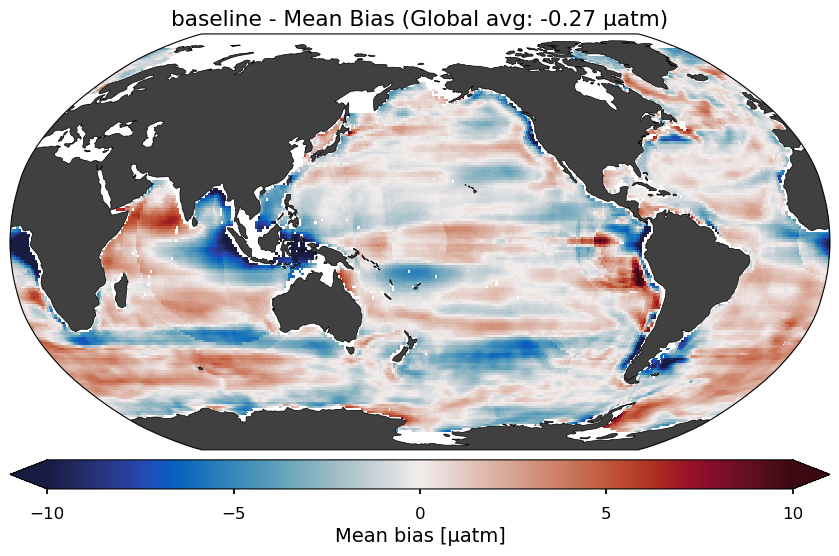


baseline - Regional Bias Statistics:
Northern Hemisphere (0-90N): -0.47 μatm
Southern Hemisphere (90S-0): -0.15 μatm
Tropics (23.5S-23.5N): -0.56 μatm
Southern Ocean (60S-35S): -0.18 μatm


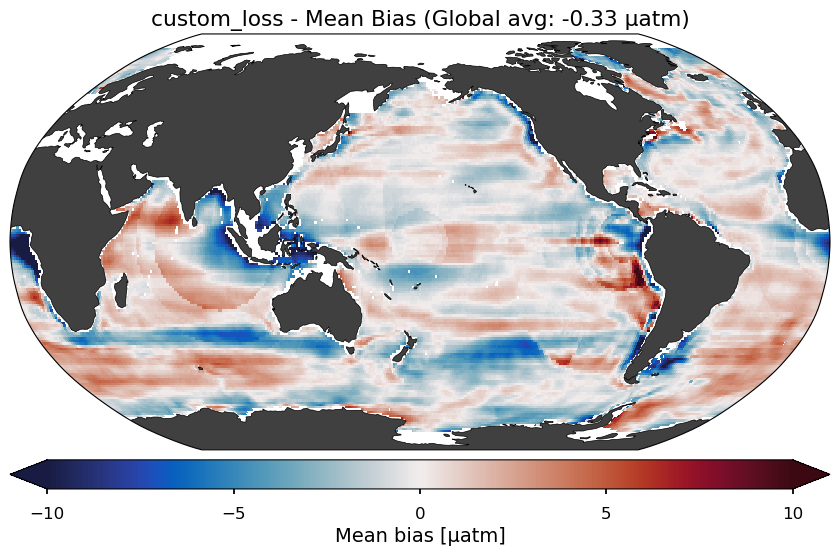


custom_loss - Regional Bias Statistics:
Northern Hemisphere (0-90N): -0.60 μatm
Southern Hemisphere (90S-0): -0.18 μatm
Tropics (23.5S-23.5N): -0.48 μatm
Southern Ocean (60S-35S): -0.28 μatm


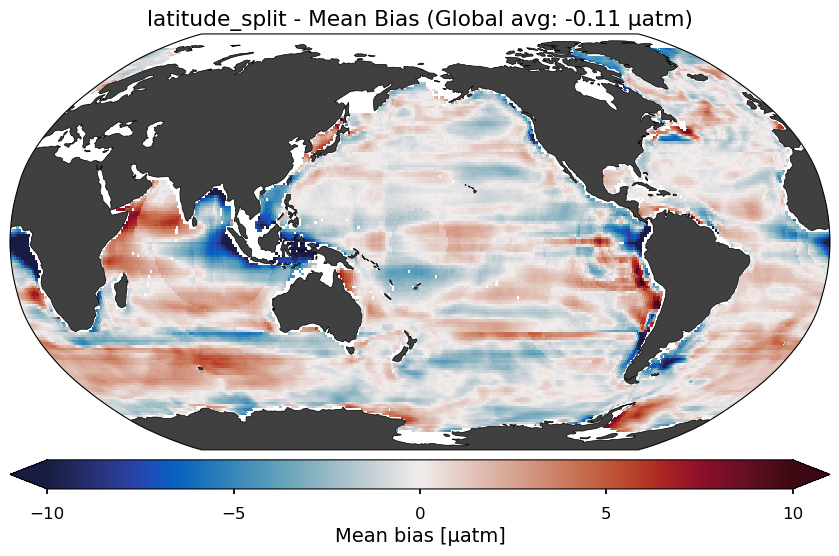


latitude_split - Regional Bias Statistics:
Northern Hemisphere (0-90N): -0.43 μatm
Southern Hemisphere (90S-0): 0.07 μatm
Tropics (23.5S-23.5N): -0.45 μatm
Southern Ocean (60S-35S): 0.33 μatm


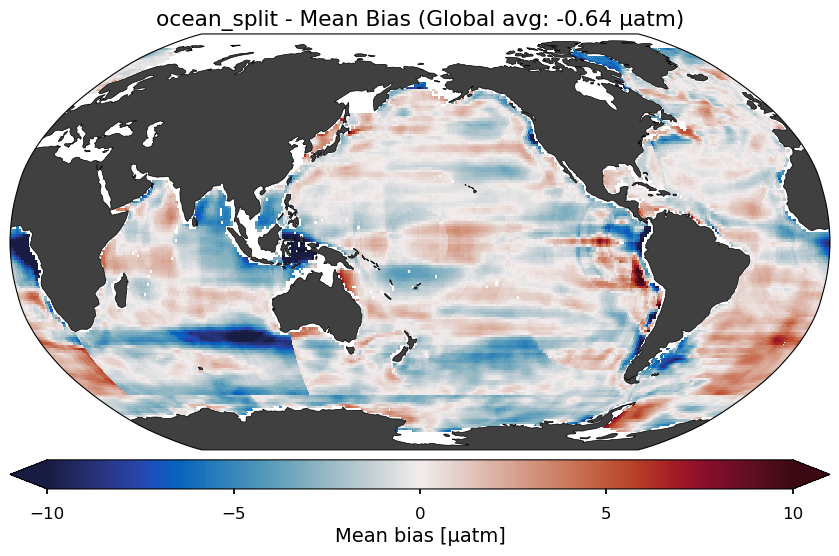


ocean_split - Regional Bias Statistics:
Northern Hemisphere (0-90N): -0.58 μatm
Southern Hemisphere (90S-0): -0.67 μatm
Tropics (23.5S-23.5N): -0.66 μatm
Southern Ocean (60S-35S): -0.88 μatm


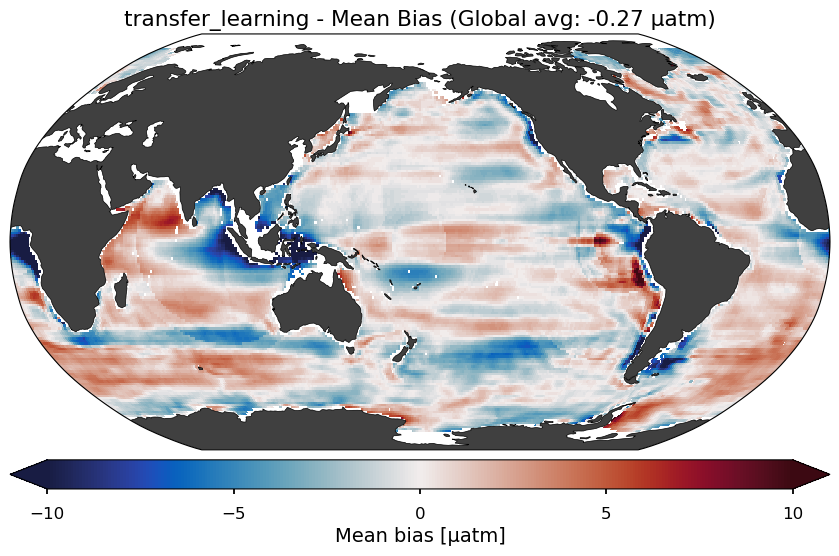


transfer_learning - Regional Bias Statistics:
Northern Hemisphere (0-90N): -0.46 μatm
Southern Hemisphere (90S-0): -0.16 μatm
Tropics (23.5S-23.5N): -0.57 μatm
Southern Ocean (60S-35S): -0.16 μatm


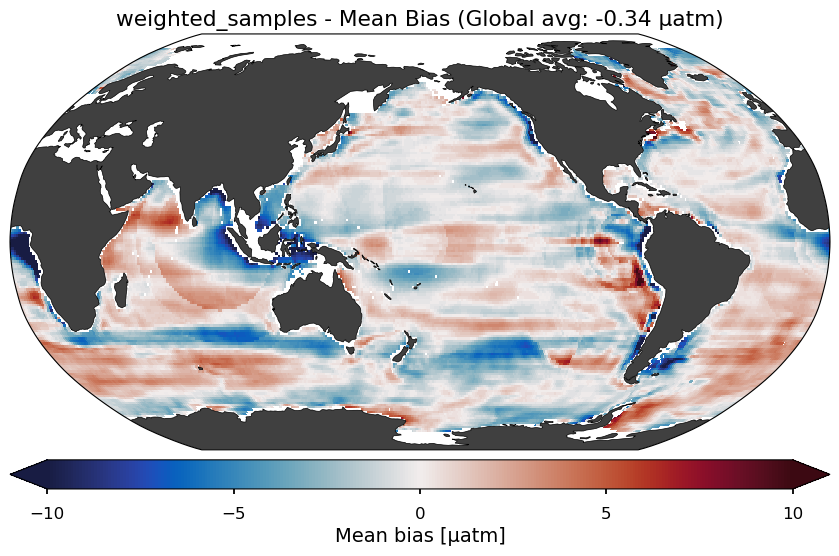


weighted_samples - Regional Bias Statistics:
Northern Hemisphere (0-90N): -0.61 μatm
Southern Hemisphere (90S-0): -0.18 μatm
Tropics (23.5S-23.5N): -0.51 μatm
Southern Ocean (60S-35S): -0.28 μatm


In [14]:
def plot_bias_comparison(eval_results):
    """Plot mean bias comparison across approaches in the same style as the starter notebook"""
    plot_style = "seaborn-v0_8-talk"
    
    # Create a figure for each approach
    for approach, ds_eval in eval_results.items():
        with plt.style.context(plot_style):
            fig = plt.figure(figsize=(8.5, 11))
            worldmap = SpatialMap2(fig=fig, region='world', 
                           cbar_mode='single',  
                           colorbar=True,  
                           cbar_location='bottom',
                           nrows_ncols=[1,1])
            
            # Set consistent colorbar range as in starter notebook
            vrange = [-10, 10, 5] 
            cmap = cm.cm.balance
            
            # Calculate mean bias
            data = (ds_eval['bias'] * 1).mean('ens').mean('member').mean('time')
            data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
            
            data = xr_add_cyclic_point(data, cyclic_coord='xlon') 
            sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                                   vrange=vrange[0:2], cmap=cmap, ax=0, linewidth_coast=0.5)
            
            # Add colorbar
            col = worldmap.add_colorbar(sub, ax=0, extend='both')
            worldmap.set_cbar_xlabel(col, 'Mean bias [μatm]', fontsize=14)
            worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
            col.ax.tick_params(labelsize=12)
            
            # Set title
            global_mean = float(data.mean())
            # plt.suptitle(f"{approach} - Mean Bias (Global avg: {global_mean:.2f} μatm)", 
            #              fontsize=16, y=0.98)
            worldmap.set_title(f"{approach} - Mean Bias (Global avg: {global_mean:.2f} μatm)", ax=0)
            plt.tight_layout(rect=[0, 0, 1, 0.96])
            # plt.savefig(f'bias_{approach}.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            # Print regional statistics similar to project3_starter.py
            print(f"\n{approach} - Regional Bias Statistics:")
            print(f"Northern Hemisphere (0-90N): {data.sel(ylat=slice(0,90)).mean().values:.2f} μatm")
            print(f"Southern Hemisphere (90S-0): {data.sel(ylat=slice(-90,0)).mean().values:.2f} μatm")
            print(f"Tropics (23.5S-23.5N): {data.sel(ylat=slice(-23.5,23.5)).mean().values:.2f} μatm")
            print(f"Southern Ocean (60S-35S): {data.sel(ylat=slice(-60,-35)).mean().values:.2f} μatm")

print("Generating bias plots for each approach...")
plot_bias_comparison(eval_results)

## 2.2 Plot correlation across timescales for each approach


Generating correlation plots for each approach...
baseline - Seasonal correlation mean: 0.900
baseline - Sub-decadal correlation mean: 0.617
baseline - Decadal correlation mean: 0.580


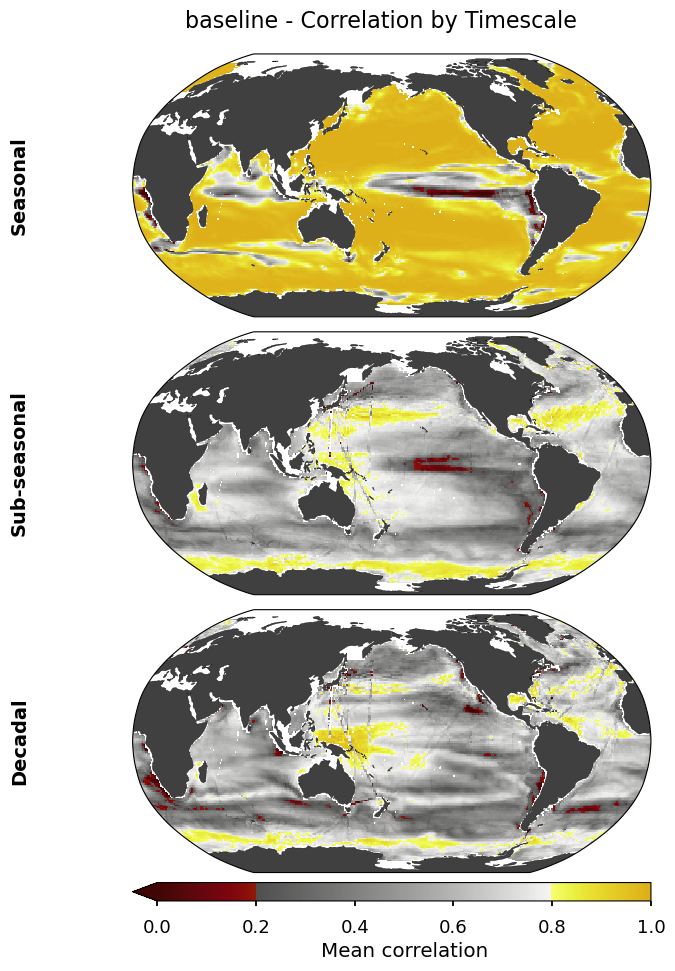

custom_loss - Seasonal correlation mean: 0.899
custom_loss - Sub-decadal correlation mean: 0.596
custom_loss - Decadal correlation mean: 0.572


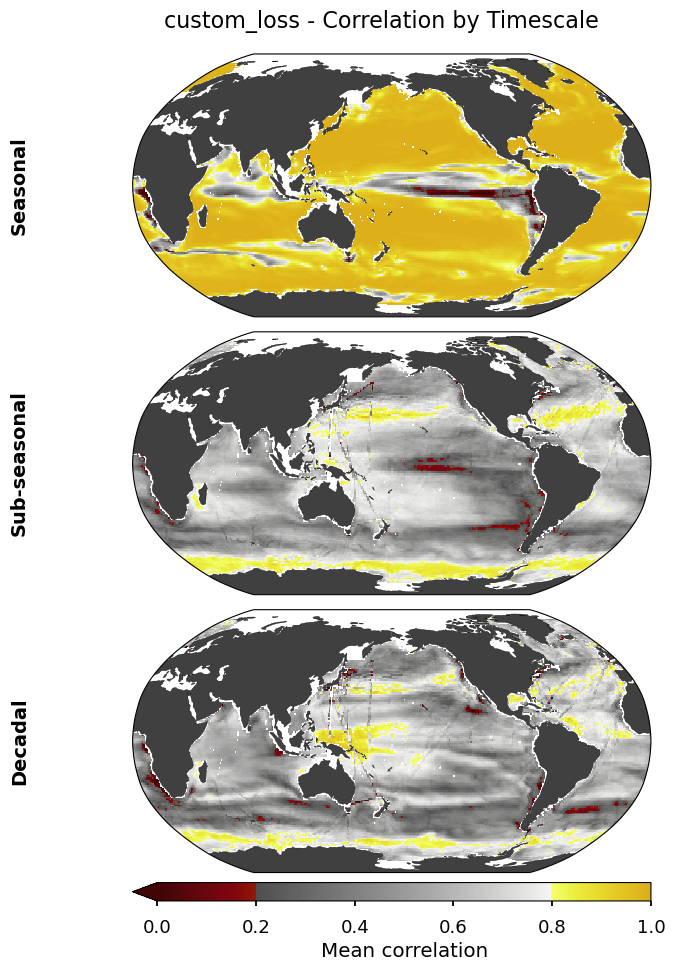

latitude_split - Seasonal correlation mean: 0.916
latitude_split - Sub-decadal correlation mean: 0.638
latitude_split - Decadal correlation mean: 0.620


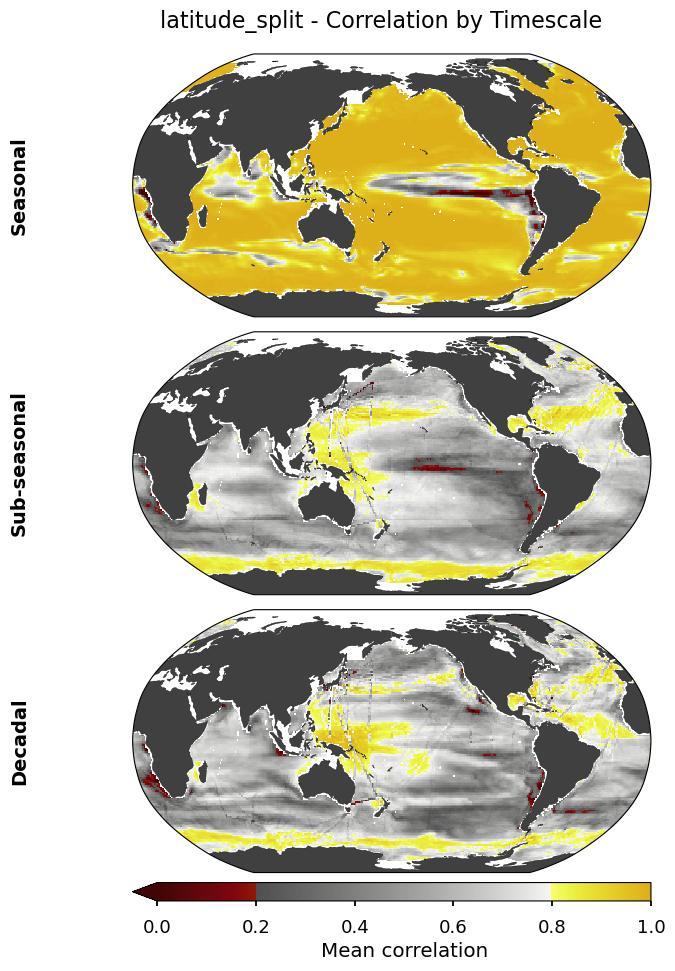

ocean_split - Seasonal correlation mean: 0.903
ocean_split - Sub-decadal correlation mean: 0.606
ocean_split - Decadal correlation mean: 0.582


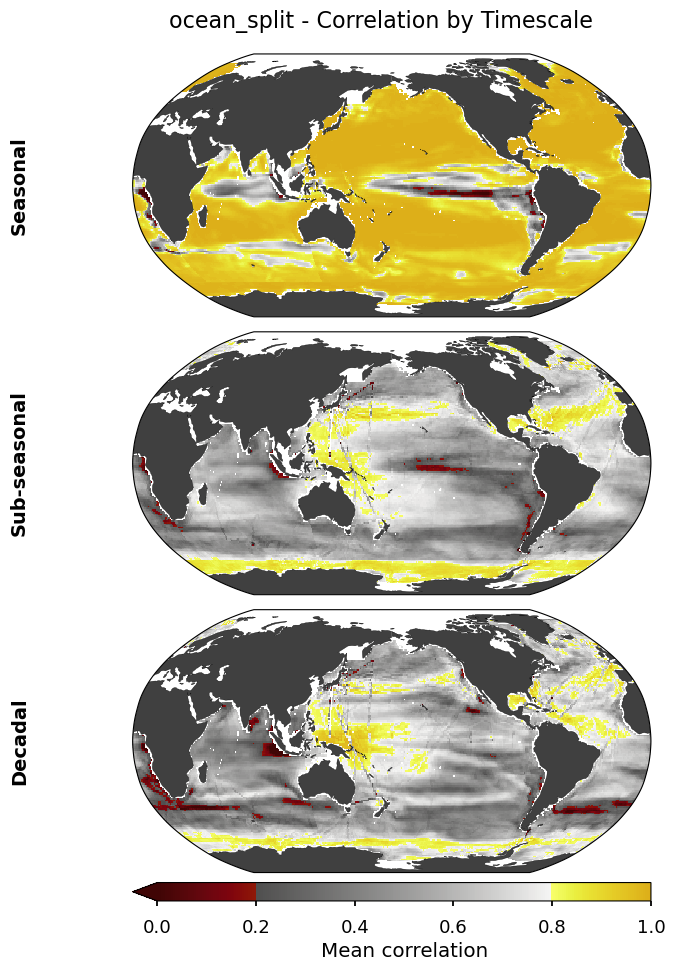

transfer_learning - Seasonal correlation mean: 0.899
transfer_learning - Sub-decadal correlation mean: 0.618
transfer_learning - Decadal correlation mean: 0.580


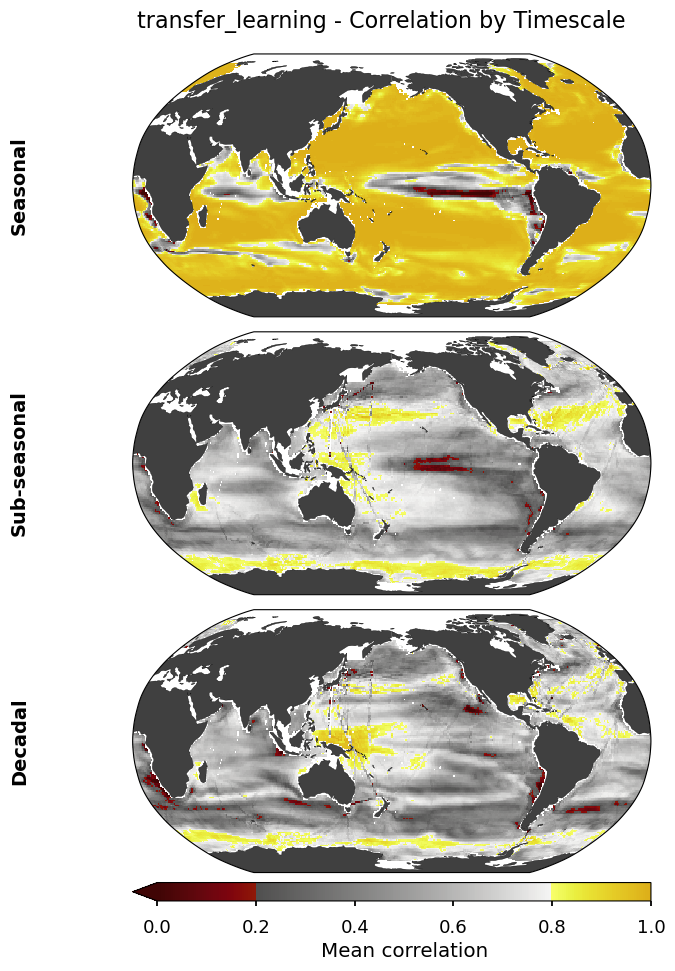

weighted_samples - Seasonal correlation mean: 0.900
weighted_samples - Sub-decadal correlation mean: 0.596
weighted_samples - Decadal correlation mean: 0.572


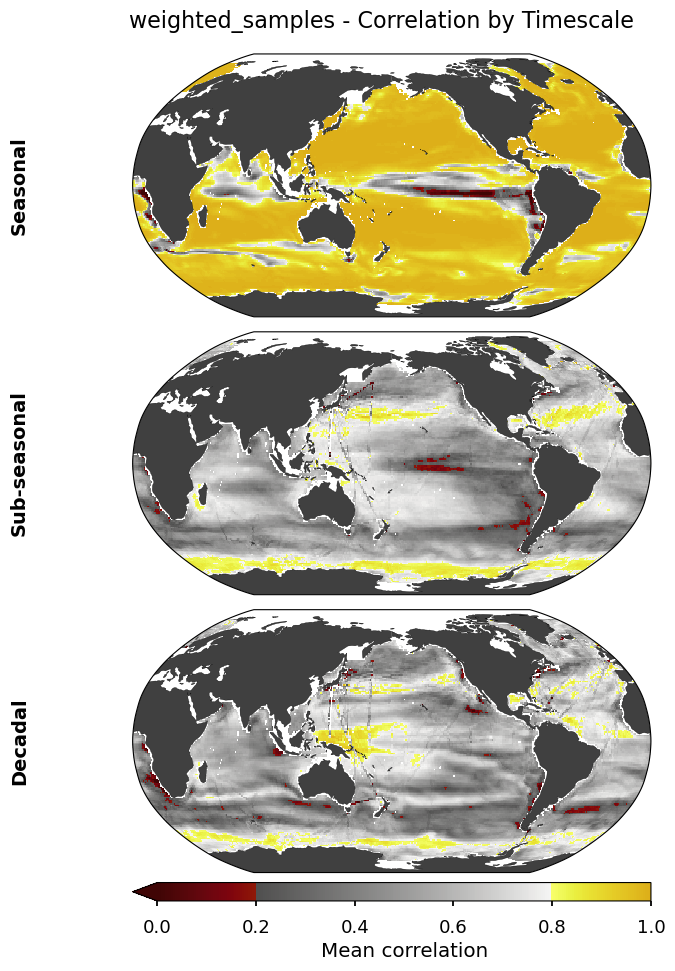

In [15]:
def plot_correlation_by_approach(corr_results):
    """Plot correlation for seasonal, sub-decadal, and decadal timescales for each approach"""
    plot_style = "seaborn-v0_8-talk"
    timescales = ['seasonal', 'residual', 'dec']  # Match the timescales used in eval_spatial
    timescale_labels = ['Seasonal', 'Sub-decadal', 'Decadal']
    
    for approach, ds_corr in corr_results.items():
        with plt.style.context(plot_style):
            # Setup Figure
            fig = plt.figure(figsize=(8.5, 11))
            worldmap = SpatialMap2(fig=fig, region='world',
                           cbar_mode='edge',
                           axes_pad=0.15,
                           colorbar=True,
                           cbar_location='bottom',
                           nrows_ncols=[3,1])
            
            # Colorbar ranges (matching starter notebook)
            vrange_col1 = [0, 1, 0.2]
            cmap_col1 = cm.cm.oxy
            
            # Plot correlation for each timescale
            for i, (timescale, label) in enumerate(zip(timescales, timescale_labels)):
                corr_var = f'corr_{timescale}'
                if corr_var in ds_corr:
                    data = ds_corr[corr_var].mean('ens').mean('member')
                    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
                    data = xr_add_cyclic_point(data, cyclic_coord='xlon')
                    sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                                          vrange=vrange_col1[0:2], cmap=cmap_col1, ax=i)
                    
                    # Calculate and print global mean correlation
                    global_mean = float(data.mean())
                    print(f"{approach} - {label} correlation mean: {global_mean:.3f}")
                else:
                    print(f"Warning: {corr_var} not found for {approach}")
            
            # Add colorbar and labels
            col1 = worldmap.add_colorbar(sub, ax=0, extend='min')
            worldmap.set_cbar_xlabel(col1, f'Mean correlation')
            worldmap.set_ticks(col1, vrange_col1[0], vrange_col1[1], vrange_col1[2])
            
            # Add side labels for each timescale, matching the starter notebook
            worldmap.grid[0].text(-0.2, 0.5, "Seasonal", transform=worldmap.grid[0].transAxes,
                                 fontsize=14, fontweight='bold', va='center', ha='right', rotation=90)
            
            worldmap.grid[1].text(-0.2, 0.5, "Sub-seasonal", transform=worldmap.grid[1].transAxes,
                                 fontsize=14, fontweight='bold', va='center', ha='right', rotation=90)
            
            worldmap.grid[2].text(-0.2, 0.5, "Decadal", transform=worldmap.grid[2].transAxes,
                                 fontsize=14, fontweight='bold', va='center', ha='right', rotation=90)
            
            plt.suptitle(f"{approach} - Correlation by Timescale", fontsize=16, y=0.92)
            # plt.savefig(f'correlation_{approach}.png', dpi=300, bbox_inches='tight')
            plt.show()

print("\nGenerating correlation plots for each approach...")
plot_correlation_by_approach(corr_results)

## 2.3 Plot RMSE for each approach


Generating RMSE plots for each approach...


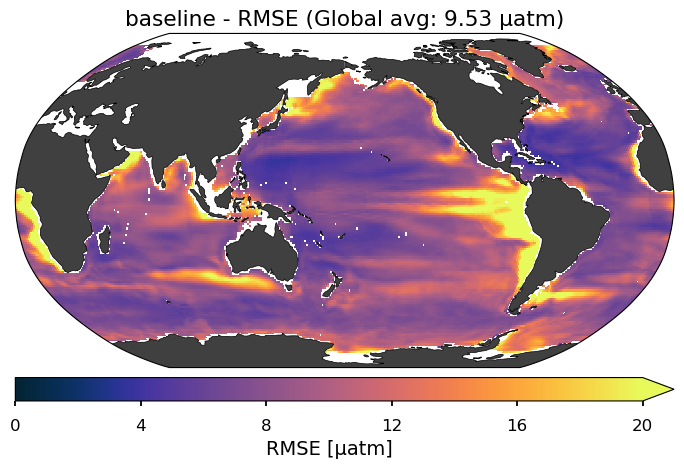


baseline - Regional RMSE Statistics:
Northern Hemisphere (0-90N): 9.10 μatm
Southern Hemisphere (90S-0): 9.77 μatm
Tropics (23.5S-23.5N): 9.64 μatm
Southern Ocean (60S-35S): 9.05 μatm


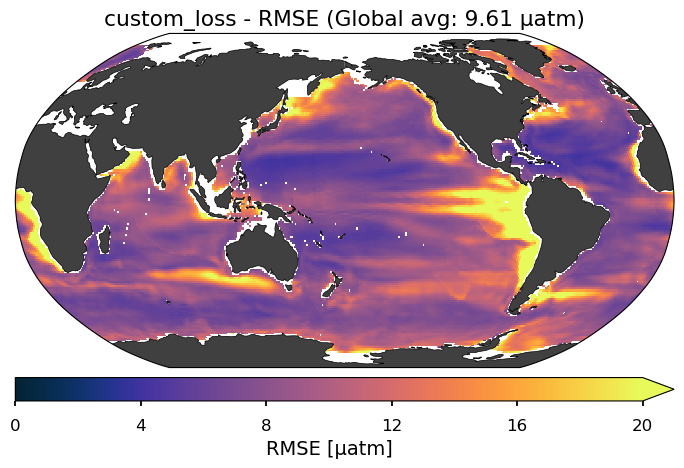


custom_loss - Regional RMSE Statistics:
Northern Hemisphere (0-90N): 9.24 μatm
Southern Hemisphere (90S-0): 9.82 μatm
Tropics (23.5S-23.5N): 9.66 μatm
Southern Ocean (60S-35S): 9.18 μatm


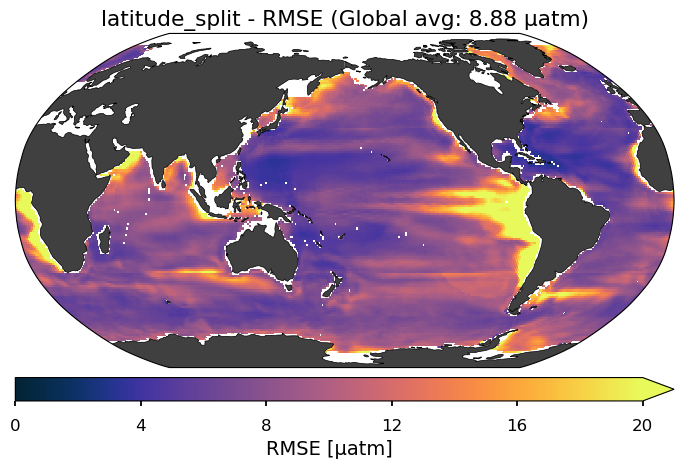


latitude_split - Regional RMSE Statistics:
Northern Hemisphere (0-90N): 8.34 μatm
Southern Hemisphere (90S-0): 9.18 μatm
Tropics (23.5S-23.5N): 9.15 μatm
Southern Ocean (60S-35S): 8.31 μatm


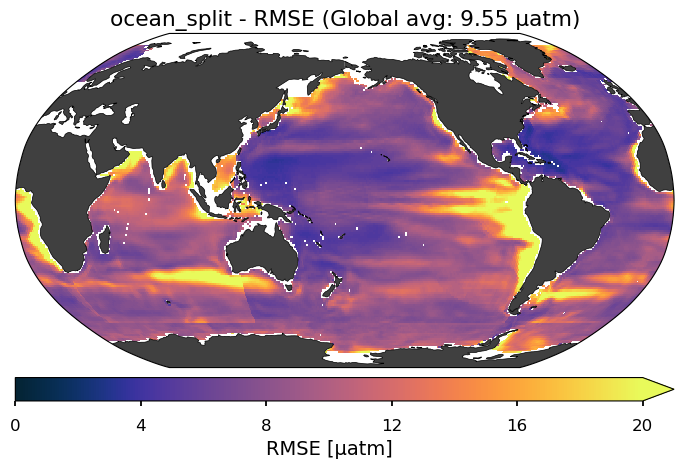


ocean_split - Regional RMSE Statistics:
Northern Hemisphere (0-90N): 8.59 μatm
Southern Hemisphere (90S-0): 10.09 μatm
Tropics (23.5S-23.5N): 9.59 μatm
Southern Ocean (60S-35S): 9.95 μatm


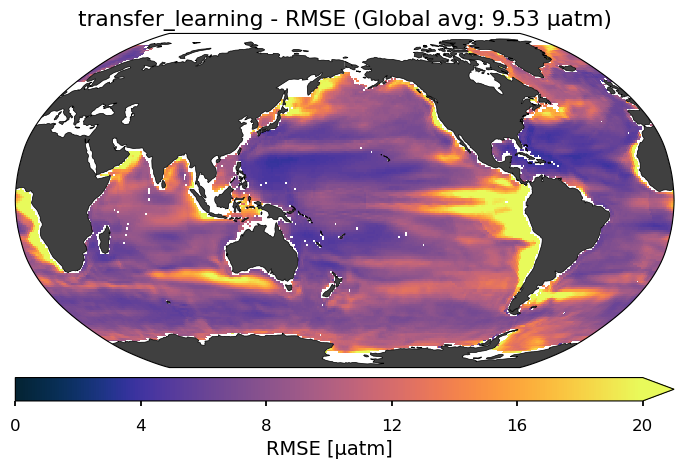


transfer_learning - Regional RMSE Statistics:
Northern Hemisphere (0-90N): 9.09 μatm
Southern Hemisphere (90S-0): 9.78 μatm
Tropics (23.5S-23.5N): 9.63 μatm
Southern Ocean (60S-35S): 9.07 μatm


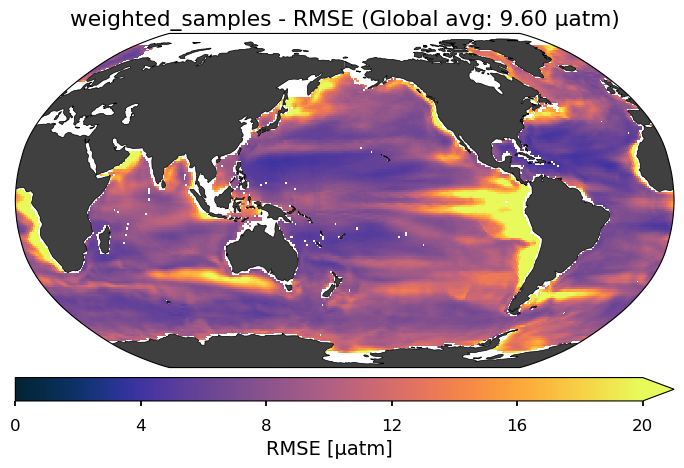


weighted_samples - Regional RMSE Statistics:
Northern Hemisphere (0-90N): 9.24 μatm
Southern Hemisphere (90S-0): 9.80 μatm
Tropics (23.5S-23.5N): 9.64 μatm
Southern Ocean (60S-35S): 9.16 μatm


In [18]:
def plot_rmse_by_approach(eval_results):
    """Plot RMSE for each approach"""
    plot_style = "seaborn-v0_8-talk"
    
    for approach, ds_eval in eval_results.items():
        with plt.style.context(plot_style):
            fig = plt.figure(figsize=(8.5, 11))
            worldmap = SpatialMap2(fig=fig, region='world', 
                           cbar_mode='single',  
                           colorbar=True,  
                           cbar_location='bottom',
                           nrows_ncols=[1,1])
            
            # Set consistent colorbar range
            vrange = [0, 20, 4] 
            cmap = cm.cm.thermal
            
            # Calculate mean RMSE
            data = ds_eval['rmse'].mean('ens').mean('member')
            data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
            
            data = xr_add_cyclic_point(data, cyclic_coord='xlon') 
            sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                                   vrange=vrange[0:2], cmap=cmap, ax=0, linewidth_coast=0.5)
            
            # Add colorbar
            col = worldmap.add_colorbar(sub, ax=0, extend='max')
            worldmap.set_cbar_xlabel(col, 'RMSE [μatm]', fontsize=14)
            worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
            col.ax.tick_params(labelsize=12)
            
            # Set title
            global_mean = float(data.mean())
            # plt.suptitle(f"{approach} - RMSE (Global avg: {global_mean:.2f} μatm)", 
            #            fontsize=16, y=0.92)
            worldmap.set_title(f"{approach} - RMSE (Global avg: {global_mean:.2f} μatm)", ax=0)
            
            # plt.savefig(f'rmse_{approach}.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            # Print regional statistics
            print(f"\n{approach} - Regional RMSE Statistics:")
            print(f"Northern Hemisphere (0-90N): {data.sel(ylat=slice(0,90)).mean().values:.2f} μatm")
            print(f"Southern Hemisphere (90S-0): {data.sel(ylat=slice(-90,0)).mean().values:.2f} μatm")
            print(f"Tropics (23.5S-23.5N): {data.sel(ylat=slice(-23.5,23.5)).mean().values:.2f} μatm")
            print(f"Southern Ocean (60S-35S): {data.sel(ylat=slice(-60,-35)).mean().values:.2f} μatm")

print("\nGenerating RMSE plots for each approach...")
plot_rmse_by_approach(eval_results)

## 2.4 Lat, Lon averages by method

Note: These plots may take up to 4 minutes to run.

In [19]:
def add_horizontal_shading(y_ranges, colors, labels, labeling=False):
    for (y_min, y_max), color, label in zip(y_ranges, colors, labels):
        plt.fill_betweenx([y_min, y_max], plt.xlim()[0], plt.xlim()[1], color=color, alpha=0.2)
        if labeling:
            mid_point = (y_min + y_max) / 2 
            plt.text(plt.xlim()[1] * 0.95, mid_point, label, color=color, fontsize=10, va='center')


y_ranges = [(30,110), (-70, 20), (150, 180), (-180, -100)]
colors = ['blue', 'green', 'red', 'red']
labels = ['Indian Ocean', 'Atlantic Ocean', 'Pacific Ocean', 'Pacific Ocean']

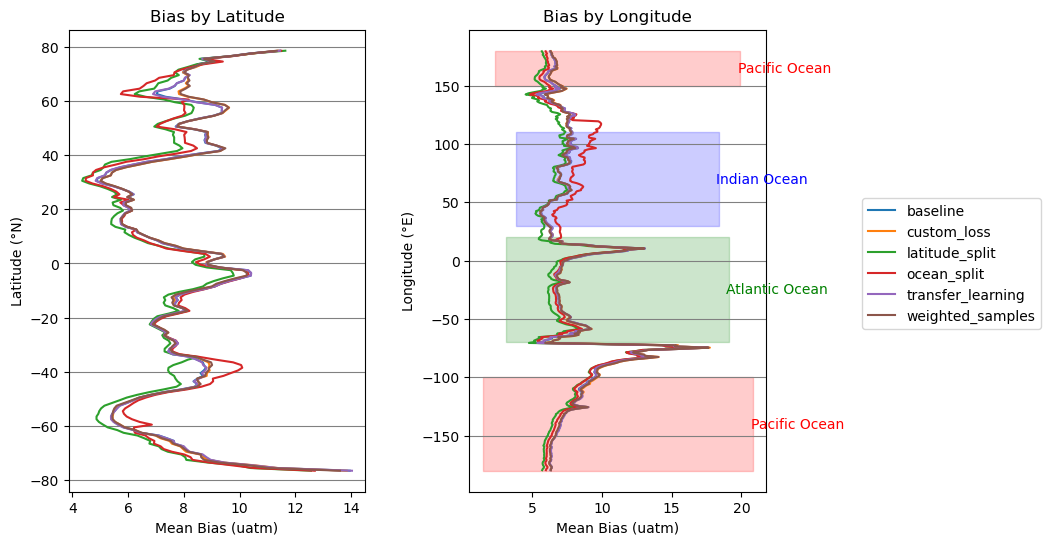

CPU times: user 3min 6s, sys: 14.9 s, total: 3min 21s
Wall time: 1min 46s


In [20]:
%%time
plt.figure(figsize=(9,6))

plt.subplot(121)
for method in eval_results.keys():
    ds_method = eval_results[method]
    np.abs(ds_method['bias']).mean(['member','time','xlon', 'ens']).plot(y='ylat', label=method)
plt.grid(axis='y', color='gray')
plt.grid(axis='y', color='gray')
plt.ylabel('Latitude (°N)')
plt.xlabel('Mean Bias (uatm)')
plt.title('Bias by Latitude')

plt.subplot(122)
for method in eval_results.keys():
    ds_method = eval_results[method]
    np.abs(ds_method['bias']).mean(['member','time','ylat', 'ens']).plot(y='xlon', label=method)
add_horizontal_shading(y_ranges, colors, labels, labeling=True)
plt.legend(bbox_to_anchor = [1.3,0.65])
plt.grid(axis='y', color='gray')
plt.ylabel('Longitude (°E)')
plt.xlabel('Mean Bias (uatm)')
plt.title('Bias by Longitude')

plt.subplots_adjust(wspace=0.35)  

plt.show();

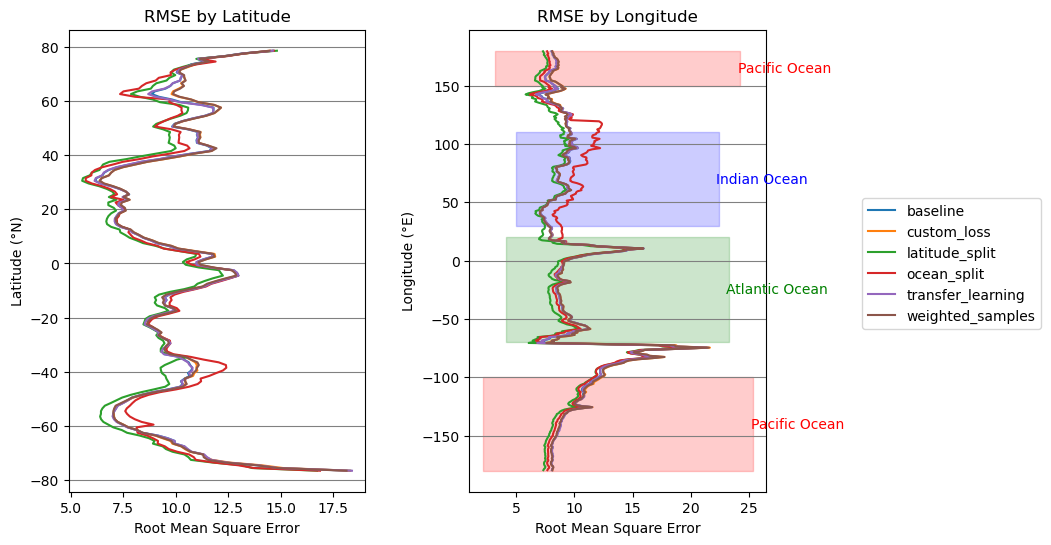

CPU times: user 3min 10s, sys: 16.2 s, total: 3min 26s
Wall time: 1min 52s


In [23]:
%%time
plt.figure(figsize=(9,6))

plt.subplot(121)
for method in eval_results.keys():
    ds_method = eval_results[method]
    np.abs(ds_method['rmse']).mean(['member','xlon', 'ens']).plot(y='ylat', label=method)
plt.grid(axis='y', color='gray')
plt.grid(axis='y', color='gray')
plt.ylabel('Latitude (°N)')
plt.xlabel('Root Mean Square Error')
plt.title('RMSE by Latitude')

plt.subplot(122)
for method in eval_results.keys():
    ds_method = eval_results[method]
    np.abs(ds_method['rmse']).mean(['member','ylat', 'ens']).plot(y='xlon', label=method)
add_horizontal_shading(y_ranges, colors, labels, labeling=True)
plt.legend(bbox_to_anchor = [1.3, 0.65])
plt.grid(axis='y', color='gray')
plt.ylabel('Longitude (°E)')
plt.xlabel('Root Mean Square Error')
plt.title('RMSE by Longitude')

plt.subplots_adjust(wspace=0.35)  

plt.show();

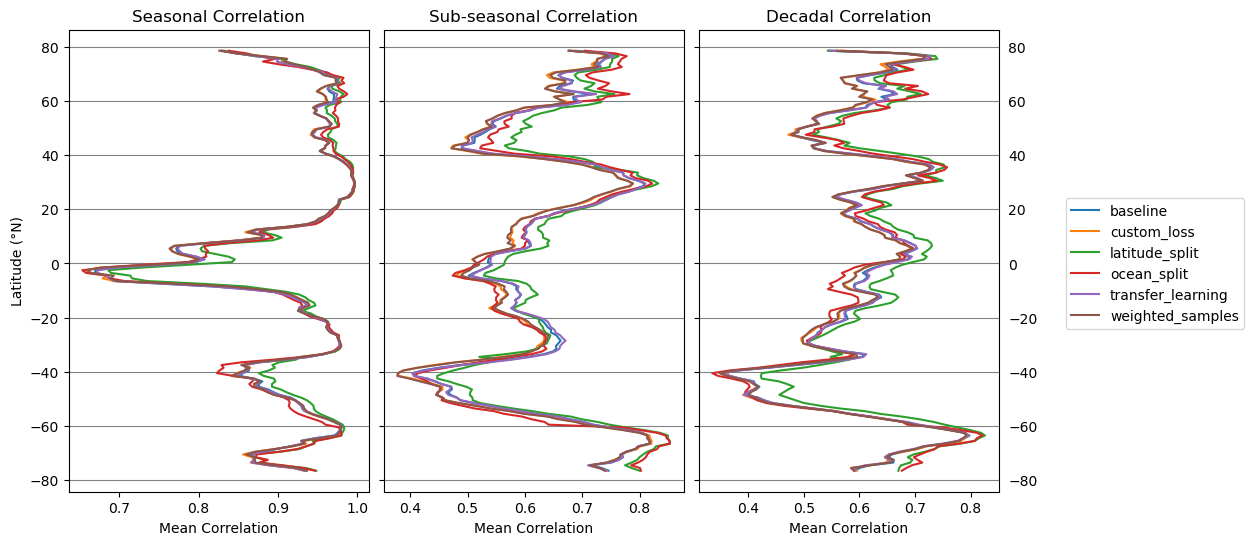

CPU times: user 612 ms, sys: 168 ms, total: 780 ms
Wall time: 455 ms


In [136]:
%%time
plt.figure(figsize=(12,6))

plt.subplot(131)
for method in eval_results.keys():
    ds_method = corr_results[method]
    np.abs(ds_method['corr_seasonal']).mean(['member','xlon', 'ens']).plot(y='ylat', label=method)
plt.grid(axis='y', color='gray')
plt.ylabel('Latitude (°N)')
plt.xlabel('Mean Correlation')
plt.title('Seasonal Correlation')

plt.subplot(132)
for method in eval_results.keys():
    ds_method = corr_results[method]
    np.abs(ds_method['corr_residual']).mean(['member','xlon', 'ens']).plot(y='ylat', label=method)
plt.grid(axis='y', color='gray')
plt.tick_params(labelleft=False)
plt.ylabel('')
plt.xlabel('Mean Correlation')
plt.title('Sub-seasonal Correlation')

plt.subplot(133)
for method in eval_results.keys():
    ds_method = corr_results[method]
    np.abs(ds_method['corr_dec']).mean(['member','xlon', 'ens']).plot(y='ylat', label=method)
plt.legend(bbox_to_anchor = [1.2, 0.65])
plt.grid(axis='y', color='gray')
plt.tick_params(labelleft=False, labelright=True)
plt.ylabel('')
plt.xlabel('Mean Correlation')
plt.title('Decadal Correlation')

plt.subplots_adjust(wspace=0.05)
plt.show();

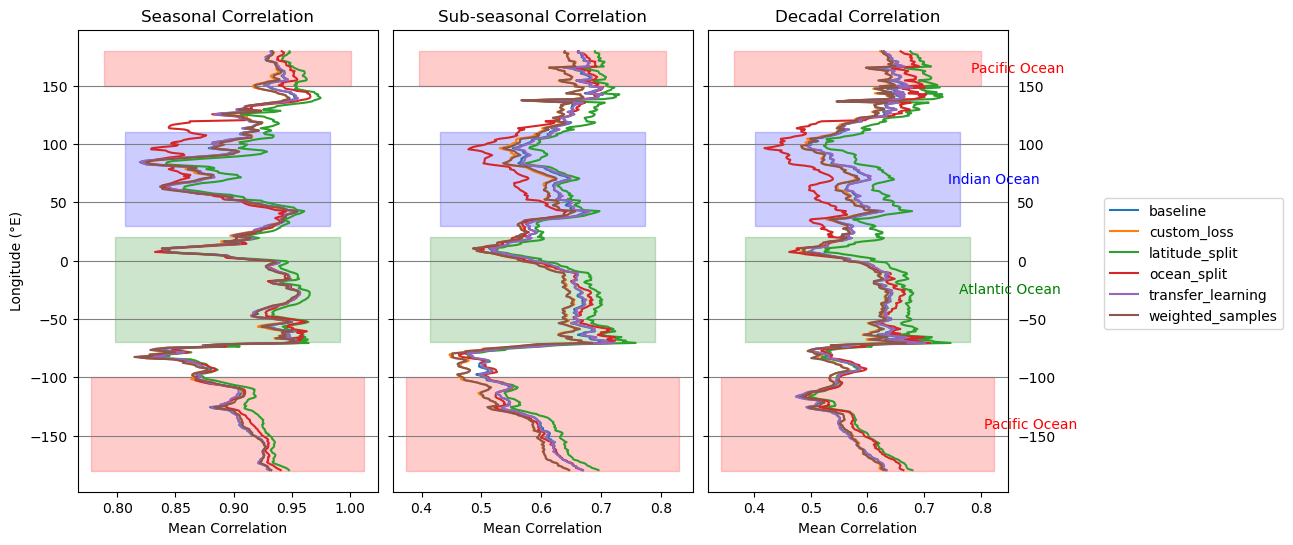

CPU times: user 708 ms, sys: 152 ms, total: 860 ms
Wall time: 537 ms


In [134]:
%%time
plt.figure(figsize=(12,6))

plt.subplot(131)
for method in eval_results.keys():
    ds_method = corr_results[method]
    np.abs(ds_method['corr_seasonal']).mean(['member','ylat', 'ens']).plot(y='xlon', label=method)
add_horizontal_shading(y_ranges, colors, labels)
plt.grid(axis='y', color='gray')
plt.ylabel('Longitude (°E)')
plt.xlabel('Mean Correlation')
plt.title('Seasonal Correlation')

plt.subplot(132)
for method in eval_results.keys():
    ds_method = corr_results[method]
    np.abs(ds_method['corr_residual']).mean(['member','ylat', 'ens']).plot(y='xlon', label=method)
add_horizontal_shading(y_ranges, colors, labels)
plt.grid(axis='y', color='gray')
plt.tick_params(labelleft=False)
plt.ylabel('')
plt.xlabel('Mean Correlation')
plt.title('Sub-seasonal Correlation')

plt.subplot(133)
for method in eval_results.keys():
    ds_method = corr_results[method]
    np.abs(ds_method['corr_dec']).mean(['member','ylat', 'ens']).plot(y='xlon', label=method)
plt.legend(bbox_to_anchor = [1.3, 0.65])
add_horizontal_shading(y_ranges, colors, labels, labeling=True)
plt.grid(axis='y', color='gray')
plt.tick_params(labelleft=False, labelright=True)
plt.ylabel('')
plt.xlabel('Mean Correlation')
plt.title('Decadal Correlation')

plt.subplots_adjust(wspace=0.05)
plt.show();

# 3. Deeper dive into the latitude_split approach

`latitude_split` was consistently our best performing method. Here, we dive deeper by evaluating performance by ESM, and looking at means by lat, lon.

In [62]:
color_dict = {'ACCESS-ESM1-5': ['indianred','maroon'],
              'CanESM5': ['yellowgreen','darkgreen'],
              'MPI-ESM1-2-LR': ['skyblue','navy']}

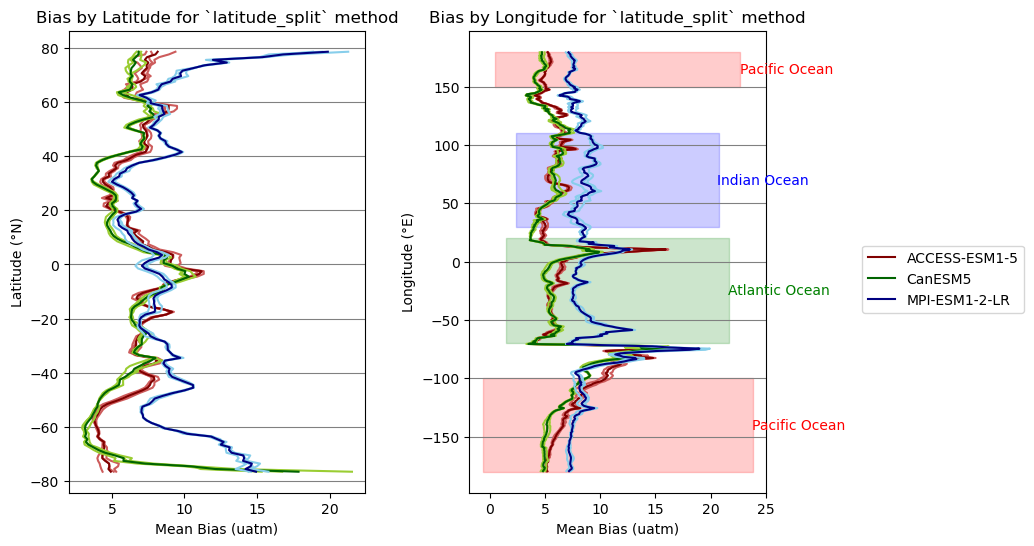

CPU times: user 40.3 s, sys: 3.69 s, total: 44 s
Wall time: 29.2 s


In [132]:
%%time
plt.figure(figsize=(9,6))

plt.subplot(121)
ds_method = eval_results['latitude_split']
for esm in ds_method.ens:
    esm = str(esm.values)
    ds_esm = ds_method.sel(member=selected_mems_dict[esm]).sel(ens=esm)
    np.abs(ds_esm['bias'].isel(member=0)).mean(['time','xlon']).plot(y='ylat', color=color_dict[esm][0])
    np.abs(ds_esm['bias'].isel(member=1)).mean(['time','xlon']).plot(y='ylat', color=color_dict[esm][0])
    np.abs(ds_esm['bias'].isel(member=2)).mean(['time','xlon']).plot(y='ylat', color=color_dict[esm][0])
    np.abs(ds_esm['bias']).mean(['member','time','xlon']).plot(y='ylat', label=esm, color=color_dict[esm][1])
plt.grid(axis='y', color='gray')
plt.grid(axis='y', color='gray')
plt.ylabel('Latitude (°N)')
plt.xlabel('Mean Bias (uatm)')
plt.title('Bias by Latitude for `latitude_split` method')

plt.subplot(122)
ds_method = eval_results['latitude_split']
for esm in ds_method.ens:
    esm = str(esm.values)
    ds_esm = ds_method.sel(member=selected_mems_dict[esm]).sel(ens=esm)
    np.abs(ds_esm['bias'].isel(member=0)).mean(['time','ylat']).plot(y='xlon', color=color_dict[esm][0])
    np.abs(ds_esm['bias'].isel(member=1)).mean(['time','ylat']).plot(y='xlon', color=color_dict[esm][0])
    np.abs(ds_esm['bias'].isel(member=2)).mean(['time','ylat']).plot(y='xlon', color=color_dict[esm][0])
    np.abs(ds_esm['bias']).mean(['member','time','ylat']).plot(y='xlon', label=esm, color=color_dict[esm][1])
add_horizontal_shading(y_ranges, colors, labels, labeling=True)
plt.legend(bbox_to_anchor = [1.3, 0.55])
plt.grid(axis='y', color='gray')
plt.grid(axis='y', color='gray')
plt.ylabel('Longitude (°E)')
plt.xlabel('Mean Bias (uatm)')
plt.title('Bias by Longitude for `latitude_split` method')

plt.subplots_adjust(wspace=0.35)            

plt.show();

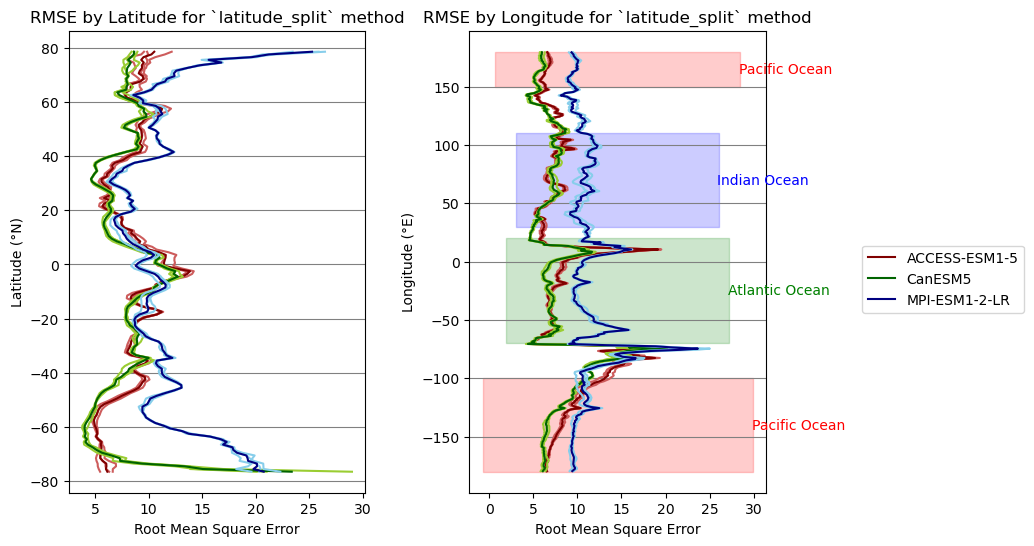

CPU times: user 38.7 s, sys: 3.66 s, total: 42.3 s
Wall time: 31 s


In [131]:
%%time
plt.figure(figsize=(9,6))

plt.subplot(121)
ds_method = eval_results['latitude_split']
for esm in ds_method.ens:
    esm = str(esm.values)
    ds_esm = ds_method.sel(member=selected_mems_dict[esm]).sel(ens=esm)
    np.abs(ds_esm['rmse'].isel(member=0)).mean(['xlon']).plot(y='ylat', color=color_dict[esm][0])
    np.abs(ds_esm['rmse'].isel(member=1)).mean(['xlon']).plot(y='ylat', color=color_dict[esm][0])
    np.abs(ds_esm['rmse'].isel(member=2)).mean(['xlon']).plot(y='ylat', color=color_dict[esm][0])
    np.abs(ds_esm['rmse']).mean(['member','xlon']).plot(y='ylat', label=esm, color=color_dict[esm][1])
plt.grid(axis='y', color='gray')
plt.grid(axis='y', color='gray')
plt.ylabel('Latitude (°N)')
plt.xlabel('Root Mean Square Error')
plt.title('RMSE by Latitude for `latitude_split` method')

plt.subplot(122)
ds_method = eval_results['latitude_split']
for esm in ds_method.ens:
    esm = str(esm.values)
    ds_esm = ds_method.sel(member=selected_mems_dict[esm]).sel(ens=esm)
    np.abs(ds_esm['rmse'].isel(member=0)).mean(['ylat']).plot(y='xlon', color=color_dict[esm][0])
    np.abs(ds_esm['rmse'].isel(member=1)).mean(['ylat']).plot(y='xlon', color=color_dict[esm][0])
    np.abs(ds_esm['rmse'].isel(member=2)).mean(['ylat']).plot(y='xlon', color=color_dict[esm][0])
    np.abs(ds_esm['rmse']).mean(['member','ylat']).plot(y='xlon', label=esm, color=color_dict[esm][1])
add_horizontal_shading(y_ranges, colors, labels, labeling=True)
plt.legend(bbox_to_anchor = [1.3,0.55])
plt.grid(axis='y', color='gray')
plt.grid(axis='y', color='gray')
plt.ylabel('Longitude (°E)')
plt.xlabel('Root Mean Square Error')
plt.title('RMSE by Longitude for `latitude_split` method')

plt.subplots_adjust(wspace=0.35)            

plt.show();

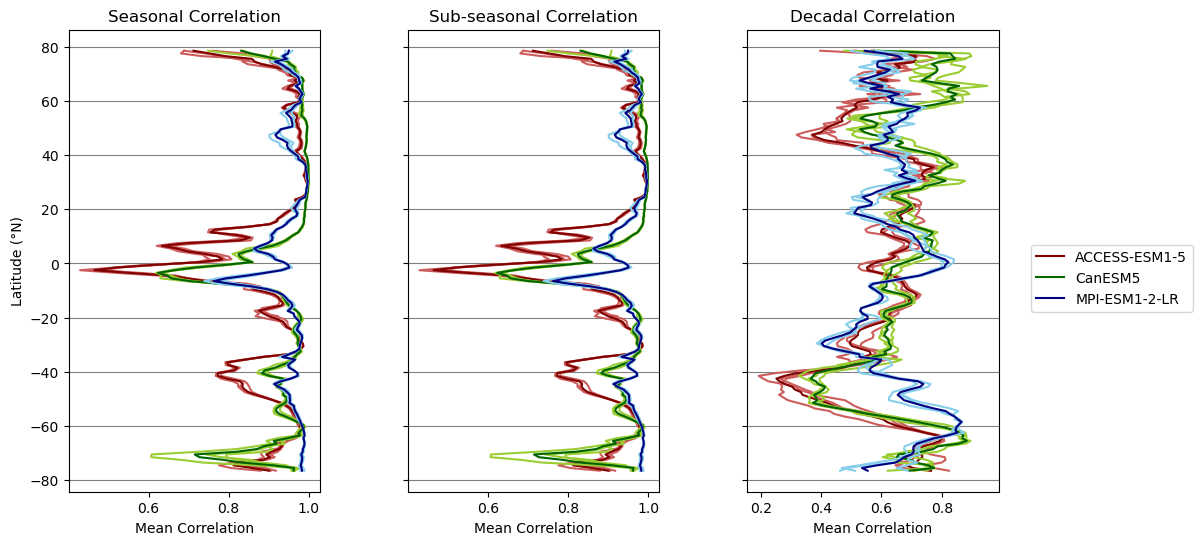

CPU times: user 605 ms, sys: 157 ms, total: 761 ms
Wall time: 483 ms


In [129]:
%%time
plt.figure(figsize=(12,6))

plt.subplot(131)
ds_method = corr_results['latitude_split']
for esm in ds_method.ens:
    esm = str(esm.values)
    ds_esm = ds_method.sel(member=selected_mems_dict[esm]).sel(ens=esm)
    np.abs(ds_esm['corr_seasonal'].isel(member=0)).mean(['xlon']).plot(y='ylat', color=color_dict[esm][0])
    np.abs(ds_esm['corr_seasonal'].isel(member=1)).mean(['xlon']).plot(y='ylat', color=color_dict[esm][0])
    np.abs(ds_esm['corr_seasonal'].isel(member=2)).mean(['xlon']).plot(y='ylat', color=color_dict[esm][0])
    np.abs(ds_esm['corr_seasonal']).mean(['member','xlon']).plot(y='ylat', label=esm, color=color_dict[esm][1])
plt.grid(axis='y', color='gray')
plt.ylabel('Latitude (°N)')
plt.xlabel('Mean Correlation')
plt.title('Seasonal Correlation')

plt.subplot(132)
ds_method = corr_results['latitude_split']
for esm in ds_method.ens:
    esm = str(esm.values)
    ds_esm = ds_method.sel(member=selected_mems_dict[esm]).sel(ens=esm)
    np.abs(ds_esm['corr_seasonal'].isel(member=0)).mean(['xlon']).plot(y='ylat', color=color_dict[esm][0])
    np.abs(ds_esm['corr_seasonal'].isel(member=1)).mean(['xlon']).plot(y='ylat', color=color_dict[esm][0])
    np.abs(ds_esm['corr_seasonal'].isel(member=2)).mean(['xlon']).plot(y='ylat', color=color_dict[esm][0])
    np.abs(ds_esm['corr_seasonal']).mean(['member','xlon']).plot(y='ylat', label=esm, color=color_dict[esm][1])
plt.grid(axis='y', color='gray')
plt.tick_params(labelleft=False)
plt.ylabel('')
plt.xlabel('Mean Correlation')
plt.title('Sub-seasonal Correlation')


plt.subplot(133)
ds_method = corr_results['latitude_split']
for esm in ds_method.ens:
    esm = str(esm.values)
    ds_esm = ds_method.sel(member=selected_mems_dict[esm]).sel(ens=esm)
    np.abs(ds_esm['corr_dec'].isel(member=0)).mean(['xlon']).plot(y='ylat', color=color_dict[esm][0])
    np.abs(ds_esm['corr_dec'].isel(member=1)).mean(['xlon']).plot(y='ylat', color=color_dict[esm][0])
    np.abs(ds_esm['corr_dec'].isel(member=2)).mean(['xlon']).plot(y='ylat', color=color_dict[esm][0])
    np.abs(ds_esm['corr_dec']).mean(['member','xlon']).plot(y='ylat', label=esm, color=color_dict[esm][1])
plt.legend(bbox_to_anchor = [1.1, 0.55])
plt.grid(axis='y', color='gray')
plt.tick_params(labelleft=False)
plt.ylabel('')
plt.xlabel('Mean Correlation')
plt.title('Decadal Correlation')

plt.subplots_adjust(wspace=0.35)            

plt.show();

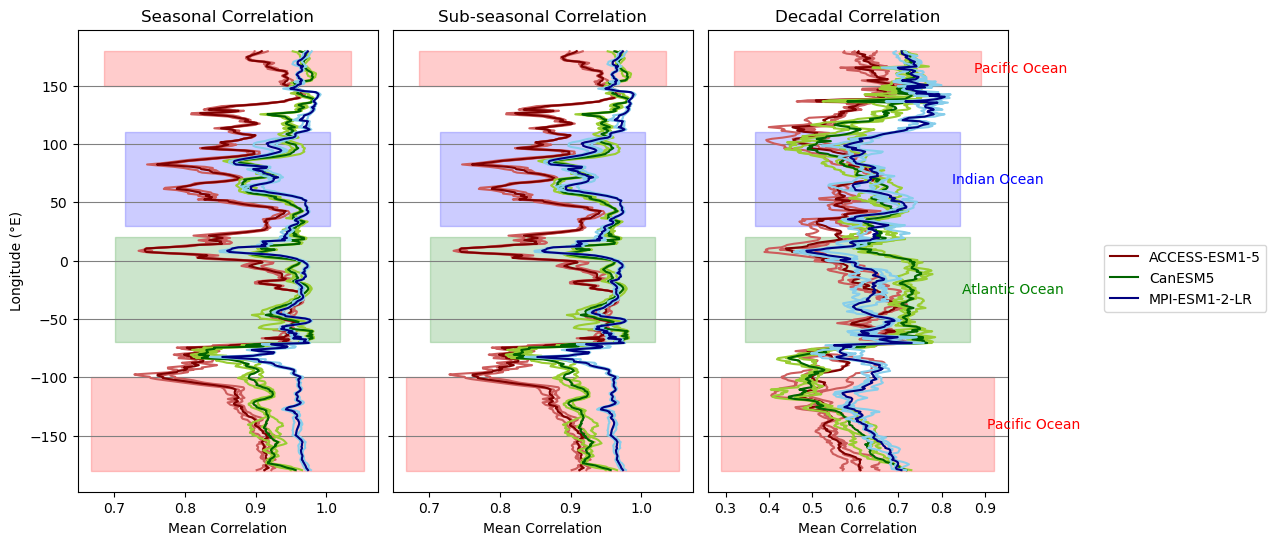

CPU times: user 753 ms, sys: 261 ms, total: 1.01 s
Wall time: 552 ms


In [130]:
%%time
plt.figure(figsize=(12, 6))

plt.subplot(131)
ds_method = corr_results['latitude_split']
for esm in ds_method.ens:
    esm = str(esm.values)
    ds_esm = ds_method.sel(member=selected_mems_dict[esm]).sel(ens=esm)
    np.abs(ds_esm['corr_seasonal'].isel(member=0)).mean(['ylat']).plot(y='xlon', color=color_dict[esm][0])
    np.abs(ds_esm['corr_seasonal'].isel(member=1)).mean(['ylat']).plot(y='xlon', color=color_dict[esm][0])
    np.abs(ds_esm['corr_seasonal'].isel(member=2)).mean(['ylat']).plot(y='xlon', color=color_dict[esm][0])
    np.abs(ds_esm['corr_seasonal']).mean(['member', 'ylat']).plot(y='xlon', label=esm, color=color_dict[esm][1])
add_horizontal_shading(y_ranges, colors, labels)
plt.grid(axis='y', color='gray')
plt.ylabel('Longitude (°E)')
plt.xlabel('Mean Correlation')
plt.title('Seasonal Correlation')

plt.subplot(132)
ds_method = corr_results['latitude_split']
for esm in ds_method.ens:
    esm = str(esm.values)
    ds_esm = ds_method.sel(member=selected_mems_dict[esm]).sel(ens=esm)
    np.abs(ds_esm['corr_seasonal'].isel(member=0)).mean(['ylat']).plot(y='xlon', color=color_dict[esm][0])
    np.abs(ds_esm['corr_seasonal'].isel(member=1)).mean(['ylat']).plot(y='xlon', color=color_dict[esm][0])
    np.abs(ds_esm['corr_seasonal'].isel(member=2)).mean(['ylat']).plot(y='xlon', color=color_dict[esm][0])
    np.abs(ds_esm['corr_seasonal']).mean(['member', 'ylat']).plot(y='xlon', label=esm, color=color_dict[esm][1])
add_horizontal_shading(y_ranges, colors, labels)
plt.grid(axis='y', color='gray')
plt.tick_params(labelleft=False)
plt.ylabel('')
plt.xlabel('Mean Correlation')
plt.title('Sub-seasonal Correlation')

plt.subplot(133)
ds_method = corr_results['latitude_split']
ax = plt.gca()  # Get the current axis
for esm in ds_method.ens:
    esm = str(esm.values)
    ds_esm = ds_method.sel(member=selected_mems_dict[esm]).sel(ens=esm)
    np.abs(ds_esm['corr_dec'].isel(member=0)).mean(['ylat']).plot(y='xlon', color=color_dict[esm][0])
    np.abs(ds_esm['corr_dec'].isel(member=1)).mean(['ylat']).plot(y='xlon', color=color_dict[esm][0])
    np.abs(ds_esm['corr_dec'].isel(member=2)).mean(['ylat']).plot(y='xlon', color=color_dict[esm][0])
    np.abs(ds_esm['corr_dec']).mean(['member', 'ylat']).plot(y='xlon', label=esm, color=color_dict[esm][1])
add_horizontal_shading(y_ranges, colors, labels, labeling=True)
plt.legend(bbox_to_anchor = [1.3, 0.55])
plt.grid(axis='y', color='gray')
plt.tick_params(labelleft=False)
plt.ylabel('')
plt.xlabel('Mean Correlation')
plt.title('Decadal Correlation')

plt.subplots_adjust(wspace=0.05)

plt.show()

# 6. Conclusion

*in progress*